# Predcition of Hospital Admission Related to Upper Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to upper respiratory tract infection (urti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_date_'+str(i), 'urti_ab_date_'+str(i), 'urti_ab_type_'+str(i),
                   'incdt_urti_date_'+str(i), 'admitted_urti_date_'+str(i), 'sgss_gp_cov_urti_date_'+str(i)]]
    
    #drop rows with no urti reord
    datum = datum[datum['urti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_i
    datum = datum[datum['sgss_gp_cov_urti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_date_'+str(i): 'urti_date', 'urti_ab_date_'+str(i): 'urti_ab_date', 
                           'urti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_date_'+str(i): 'incdt_urti_date', 'incdt_urti_type_'+str(i): 'incdt_urti_type',
                           'admitted_urti_date_'+str(i): 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_'+str(i): 'sgss_gp_cov_urti_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')

In [19]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [20]:
#process 20 urtis and concatenate them 
data_urti_1 = proc_infec_data(data,1)
data_urti_2 = proc_infec_data(data,2)
data_urti_3 = proc_infec_data(data,3)
data_urti_4 = proc_infec_data(data,4)
data_urti_5 = proc_infec_data(data,5)
data_urti_6 = proc_infec_data(data,6)
data_urti_7 = proc_infec_data(data,7)
data_urti_8 = proc_infec_data(data,8)
data_urti_9 = proc_infec_data(data,9)
data_urti_10 = proc_infec_data(data,10)
data_urti_11 = proc_infec_data(data,11)
data_urti_12 = proc_infec_data(data,12)
data_urti_13 = proc_infec_data(data,13)
data_urti_14 = proc_infec_data(data,14)
data_urti_15 = proc_infec_data(data,15)
data_urti_16 = proc_infec_data(data,16)
data_urti_17 = proc_infec_data(data,17)
data_urti_18 = proc_infec_data(data,18)
data_urti_19 = proc_infec_data(data,19)
data_urti_20 = proc_infec_data(data,20)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4, data_urti_5, data_urti_6, data_urti_7, data_urti_8, data_urti_9, data_urti_10, data_urti_11, data_urti_12, data_urti_13, data_urti_14, data_urti_15, data_urti_16, data_urti_17, data_urti_18, data_urti_19, data_urti_20])
data_urti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [21]:
##add variable season
#convert data types
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['urti_date'] 
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti = data_urti[data_urti['date'] != last_1_month_date_y_m]
data_urti = data_urti[data_urti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti['season'] = np.select(conditions, choices, default='winter')

In [22]:
#add variable time period
data_urti.loc[(data_urti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti.loc[((data_urti['date'] >= '2020-01') & (data_urti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_urti.loc[(data_urti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [23]:
#scenario 1
#not hosped (nothing happened)
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0

In [24]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]

In [25]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0

#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [26]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30

#give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [27]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [28]:
#drop anybody with age less than 18 or 0!
data_urti = data_urti[~(data_urti['age'] < 18)] 
data_urti['age'][data_urti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti = data_urti[data_urti['age_cat'] != '0-4']
data_urti = data_urti[data_urti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

In [29]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking_status": dict_smoking})

In [30]:
#drop rows with missing region
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
   data_urti = data_urti[data_urti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_urti.columns) and (data_urti['smoking_status'].isnull().sum() > 0):
    data_urti['smoking_status'] = data_urti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    data_urti['imd'] = data_urti['imd'].fillna(0)

In [31]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti['bmi_cat'] = 5

for idx, x in enumerate(data_urti['bmi_cat']):
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 30:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 25) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 30):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 18.5) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 25):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 18.5:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

In [32]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti['ab_type_cat'] = np.where(data_urti['ab_type'].isin(ab_series[mask].index),'other',data_urti['ab_type'])
#assign no to non ab users
data_urti.loc[data_urti['urti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti['ab_type_cat'] = data_urti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [33]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking_status": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
data_urti = data_urti.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [34]:
#categorise CCI
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti['antibacterial_brit'].clip(0, data_urti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

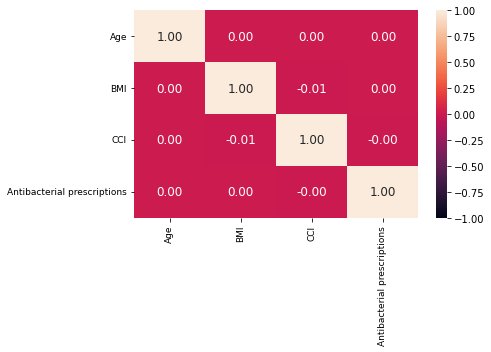

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [36]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'urti_ab_date', 'ab_type_cat', 'incdt_urti_date', 'date', 'period',
                                   'event_urti_admitted', 'duration_urti_admitted'
                                    ]]

In [37]:
#incident and prevalent infection 
data_urti_incdt = data_urti[data_urti['incdt_urti_date'] == 0]
data_urti_prevl = data_urti[data_urti['incdt_urti_date'] == 1]
#switch variable urti_ab_date into a binary variable
data_urti_incdt[['urti_ab_date']] = data_urti_incdt[['urti_ab_date']].where(data_urti_incdt[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_urti_prevl[['urti_ab_date']] = data_urti_prevl[['urti_ab_date']].where(data_urti_prevl[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_urti_incdt_males = data_urti_incdt[data_urti_incdt['sex'] == 'male']
data_urti_incdt_females = data_urti_incdt[data_urti_incdt['sex'] == 'female']
data_urti_prevl_males = data_urti_prevl[data_urti_prevl['sex'] == 'male']
data_urti_prevl_females = data_urti_prevl[data_urti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_urti_incdt_15_24 = data_urti_incdt[data_urti_incdt['age_cat'] == '15_24']
data_urti_incdt_25_34 = data_urti_incdt[data_urti_incdt['age_cat'] == '25_34']
data_urti_incdt_35_44 = data_urti_incdt[data_urti_incdt['age_cat'] == '35_44']
data_urti_incdt_45_54 = data_urti_incdt[data_urti_incdt['age_cat'] == '45_54']
data_urti_incdt_55_64 = data_urti_incdt[data_urti_incdt['age_cat'] == '55_64']
data_urti_incdt_65_74 = data_urti_incdt[data_urti_incdt['age_cat'] == '65_74']
data_urti_incdt_75_more = data_urti_incdt[data_urti_incdt['age_cat'] == '75_more']
data_urti_prevl_15_24 = data_urti_prevl[data_urti_prevl['age_cat'] == '15_24']
data_urti_prevl_25_34 = data_urti_prevl[data_urti_prevl['age_cat'] == '25_34']
data_urti_prevl_35_44 = data_urti_prevl[data_urti_prevl['age_cat'] == '35_44']
data_urti_prevl_45_54 = data_urti_prevl[data_urti_prevl['age_cat'] == '45_54']
data_urti_prevl_55_64 = data_urti_prevl[data_urti_prevl['age_cat'] == '55_64']
data_urti_prevl_65_74 = data_urti_prevl[data_urti_prevl['age_cat'] == '65_74']
data_urti_prevl_75_more = data_urti_prevl[data_urti_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_urti_incdt_prepandemic = data_urti_incdt[data_urti_incdt['date'] <= '2019-12']
data_urti_incdt_during_pandemic = data_urti_incdt[(data_urti_incdt['date'] >= '2020-03') & (data_urti_incdt['date']<= '2021-03')]
data_urti_incdt_post_2nd_lockdown = data_urti_incdt[data_urti_incdt['date'] <= '2021-04']
data_urti_prevl_prepandemic = data_urti_prevl[data_urti_prevl['date'] <= '2019-12']
data_urti_prevl_during_pandemic = data_urti_prevl[(data_urti_prevl['date'] >= '2020-03') & (data_urti_prevl['date']<= '2021-03')]
data_urti_prevl_post_2nd_lockdown = data_urti_prevl[data_urti_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['urti_ab_date'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['urti_ab_date'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['urti_ab_date'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['urti_ab_date'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_urti
# save data
data_urti.to_csv('../output/hospitalisation_prediction_urti/data_urti.csv')

Stored 'data_urti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident urti with no antibiotics

<lifelines.CoxPHFitter: fitted with 112511 total observations, 111678 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 112511
number of events observed = 833
   partial log-likelihood = -9658.51
         time fit was run = 2023-03-27 16:50:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.24       0.11             0.01             0.42                 1.01                 1.52
CCI_cat[T.medium]                0.07       1.07       0.12            -0.17             0.30                 0.85                 1.35
CCI_cat[T.high]                 -0.05       0.95       0.15            -0.34             0.24                 0.71                 1.27
CCI_cat[T.very_high]             0.03       1.03       0.12            -0.21             0.28                 0.81                 1.32
age_cat[T.25_34]                -0.05       0.95       0.13            -0.30             0.21                 0.74                 1.23
age_cat[T.35_44]                -0.11       0.89       0.13            -0.37             0.14                 0.69                 1.15
age_cat[T.45_54]                 0.07       1.07       0.13            -0.18             0.32                 0.84                 1.37
age_cat[T.55_64]                -0.03       0.97       0.13            -0.28             0.22                 0.75                 1.25
age_cat[T.65_74]                -0.08       0.92       0.13            -0.34             0.17                 0.71                 1.19
age_cat[T.75_more]              -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.27
antibacterial_brit               0.02       1.02       0.02            -0.03             0.07                 0.97                 1.07
bmi_cat[T.obese]                 0.17       1.18       0.14            -0.10             0.43                 0.91                 1.54
bmi_cat[T.overweight]            0.01       1.01       0.17            -0.32             0.33                 0.73                 1.40
bmi_cat[T.underweight]           0.11       1.11       0.23            -0.34             0.56                 0.71                 1.75
bmi_cat[T.unknown]               0.02       1.02       0.15            -0.26             0.31                 0.77                 1.36
ethnicity[T.unknown]             0.29       1.34       0.12             0.05             0.54                 1.05                 1.71
ethnicity[T.white]               0.36       1.44       0.11             0.14             0.58                 1.16                 1.79
flu_vaccine[T.yes]              -0.06       0.95       0.12            -0.29             0.17                 0.75                 1.19
imd[T.medium]                    0.08       1.09       0.11            -0.13             0.30                 0.87                 1.35
imd[T.unaffluent]                0.02       1.02       0.11            -0.20             0.24                 0.82                 1.27
imd[T.unknown]                   0.10       1.10       0.17            -0.23             0.43                 0.79                 1.53
imd[T.very_affluent]            -0.04       0.96       0.11            -0.26             0.19                 0.77                 1.20
imd[T.very_unaffluent]          -0.07       0.93       0.11            -0.29             0.16                 0.75                 1.17
region[T.east_midlands]         -0.01       0.99       0.17            -0.33             0.32                 0.72                 1.38
region[T.london]                 0.09       1.09       0.14      

12759


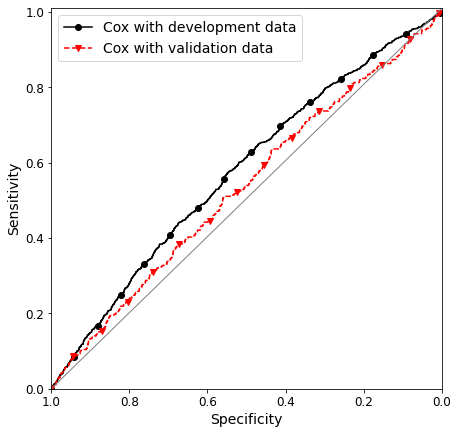

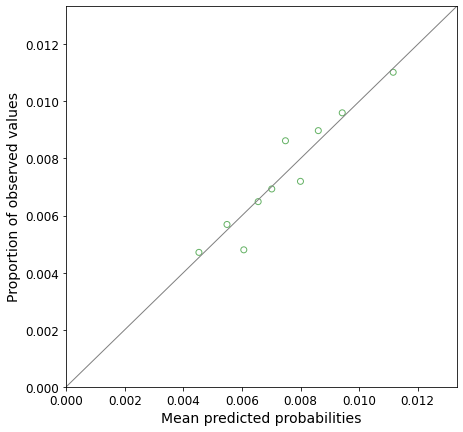

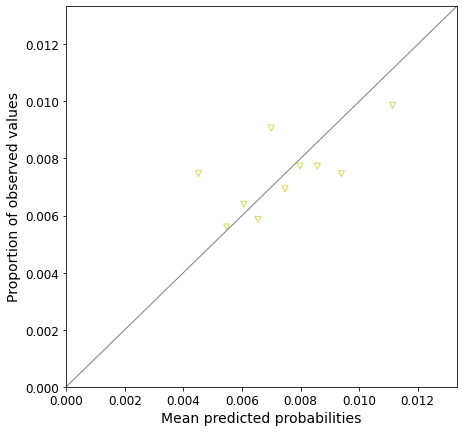

In [39]:
#data prep
data, data_urti_no_abs_incdt_enc = cox_data_prep(data_urti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'no_abs_incdt', data_urti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'no_abs_incdt', data_urti_no_abs_incdt)

try:
    #build cox model 
    cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = cox_model_build('urti', 'no_abs_incdt', data_urti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_no_abs_incdt, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_no_abs_incdt.csv', data_urti_no_abs_incdt_enc, data_urti_no_abs_incdt, 'sum_betas_cph_urti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_no_abs_incdt, 'event_urti_admitted', data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, 'event_urti_admitted', data_urti_no_abs_incdt_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_no_abs_incdt_train.jpg', 'calibration_cph_urti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_no_abs_incdt, 'urti', 'no_abs_incdt', data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident urti with antibiotics

<lifelines.CoxPHFitter: fitted with 12572 total observations, 12477 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 12572
number of events observed = 95
   partial log-likelihood = -880.24
         time fit was run = 2023-03-27 16:50:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.31            -0.69             0.52                 0.50                 1.68
CCI_cat[T.medium]               -0.09       0.91       0.34            -0.76             0.57                 0.47                 1.77
CCI_cat[T.high]                  0.27       1.31       0.37            -0.46             1.01                 0.63                 2.73
CCI_cat[T.very_high]            -0.04       0.96       0.35            -0.74             0.65                 0.48                 1.92
age_cat[T.25_34]                -0.24       0.79       0.37            -0.96             0.49                 0.38                 1.62
age_cat[T.35_44]                -0.42       0.66       0.39            -1.18             0.34                 0.31                 1.41
age_cat[T.45_54]                -0.33       0.72       0.37            -1.05             0.39                 0.35                 1.48
age_cat[T.55_64]                -0.89       0.41       0.45            -1.77            -0.01                 0.17                 0.99
age_cat[T.65_74]                -0.41       0.67       0.39            -1.17             0.35                 0.31                 1.42
age_cat[T.75_more]               0.24       1.28       0.32            -0.38             0.87                 0.68                 2.39
antibacterial_brit               0.01       1.01       0.07            -0.13             0.16                 0.88                 1.17
bmi_cat[T.obese]                 0.59       1.80       0.52            -0.43             1.61                 0.65                 5.02
bmi_cat[T.overweight]            0.89       2.42       0.57            -0.24             2.01                 0.79                 7.45
bmi_cat[T.underweight]           1.19       3.28       0.67            -0.13             2.51                 0.88                12.24
bmi_cat[T.unknown]               0.81       2.25       0.54            -0.24             1.86                 0.79                 6.42
ethnicity[T.unknown]            -0.63       0.53       0.31            -1.24            -0.01                 0.29                 0.99
ethnicity[T.white]              -0.46       0.63       0.25            -0.95             0.04                 0.39                 1.04
flu_vaccine[T.yes]              -0.11       0.89       0.37            -0.84             0.61                 0.43                 1.84
imd[T.medium]                   -0.48       0.62       0.33            -1.13             0.17                 0.32                 1.19
imd[T.unaffluent]               -0.59       0.56       0.34            -1.25             0.08                 0.29                 1.08
imd[T.unknown]                  -0.24       0.78       0.49            -1.21             0.73                 0.30                 2.07
imd[T.very_affluent]            -0.15       0.86       0.30            -0.75             0.44                 0.47                 1.55
imd[T.very_unaffluent]          -0.38       0.69       0.32            -1.01             0.25                 0.37                 1.28
region[T.east_midlands]          0.12       1.13       0.43            -0.72             0.96                 0.49                 2.62
region[T.london]                -0.24       0.78       0.40           

12783


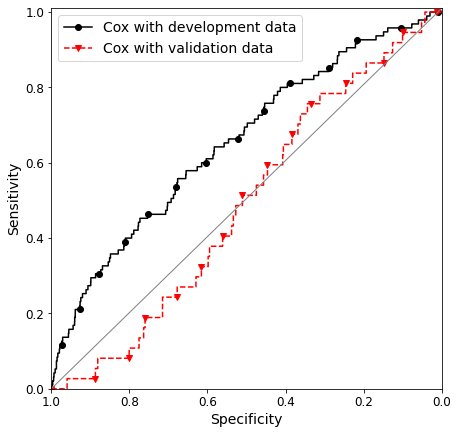

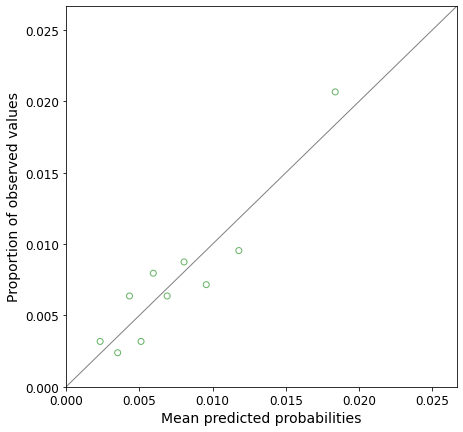

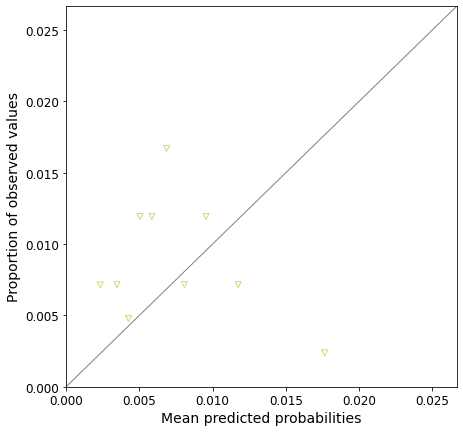

In [40]:
#data prep
data, data_urti_abs_incdt_enc = cox_data_prep(data_urti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'abs_incdt', data_urti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'abs_incdt', data_urti_abs_incdt)

try:
    #build cox model 
    cph_urti_abs_incdt, data_urti_abs_incdt_train, data_urti_abs_incdt_test = cox_model_build('urti', 'abs_incdt', data_urti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_abs_incdt, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_abs_incdt.csv', data_urti_abs_incdt_enc, data_urti_abs_incdt, 'sum_betas_cph_urti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_abs_incdt, 'event_urti_admitted', data_urti_abs_incdt_train, data_urti_abs_incdt_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, 'event_urti_admitted', data_urti_abs_incdt_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_abs_incdt_train.jpg', 'calibration_cph_urti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_abs_incdt, 'urti', 'abs_incdt', data_urti_abs_incdt_train, data_urti_abs_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent urti with no antibiotics

<lifelines.CoxPHFitter: fitted with 12600 total observations, 12511 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 12600
number of events observed = 89
   partial log-likelihood = -819.57
         time fit was run = 2023-03-27 16:50:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.93       0.39       0.29            -1.49            -0.37                 0.22                 0.69
CCI_cat[T.medium]               -0.73       0.48       0.32            -1.35            -0.11                 0.26                 0.90
CCI_cat[T.high]                 -0.76       0.47       0.40            -1.55             0.04                 0.21                 1.04
CCI_cat[T.very_high]            -0.54       0.58       0.32            -1.16             0.09                 0.31                 1.09
age_cat[T.25_34]                 0.35       1.43       0.35            -0.33             1.04                 0.72                 2.83
age_cat[T.35_44]                -0.01       0.99       0.38            -0.75             0.73                 0.47                 2.07
age_cat[T.45_54]                -0.12       0.89       0.39            -0.89             0.65                 0.41                 1.92
age_cat[T.55_64]                -0.69       0.50       0.46            -1.60             0.21                 0.20                 1.24
age_cat[T.65_74]                -0.49       0.61       0.43            -1.33             0.35                 0.27                 1.42
age_cat[T.75_more]              -0.06       0.94       0.39            -0.82             0.69                 0.44                 2.00
antibacterial_brit               0.04       1.04       0.07            -0.11             0.18                 0.90                 1.20
bmi_cat[T.obese]                 0.10       1.10       0.44            -0.76             0.95                 0.47                 2.59
bmi_cat[T.overweight]            0.45       1.57       0.49            -0.51             1.41                 0.60                 4.09
bmi_cat[T.underweight]           0.49       1.64       0.65            -0.78             1.76                 0.46                 5.81
bmi_cat[T.unknown]               0.20       1.22       0.46            -0.70             1.10                 0.50                 3.00
ethnicity[T.unknown]            -0.33       0.72       0.35            -1.03             0.36                 0.36                 1.44
ethnicity[T.white]              -0.01       0.99       0.29            -0.58             0.56                 0.56                 1.76
flu_vaccine[T.yes]               0.44       1.55       0.30            -0.15             1.03                 0.86                 2.80
imd[T.medium]                    0.44       1.56       0.36            -0.25             1.14                 0.78                 3.14
imd[T.unaffluent]                0.14       1.15       0.38            -0.60             0.88                 0.55                 2.42
imd[T.unknown]                  -0.16       0.85       0.64            -1.42             1.10                 0.24                 3.00
imd[T.very_affluent]             0.44       1.56       0.36            -0.26             1.15                 0.77                 3.14
imd[T.very_unaffluent]           0.31       1.36       0.36            -0.41             1.02                 0.67                 2.78
region[T.east_midlands]          0.00       1.00       0.45            -0.87             0.88                 0.42                 2.41
region[T.london]                -0.08       0.93       0.39           

12779


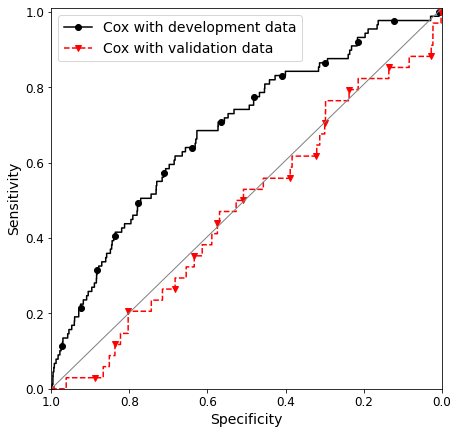

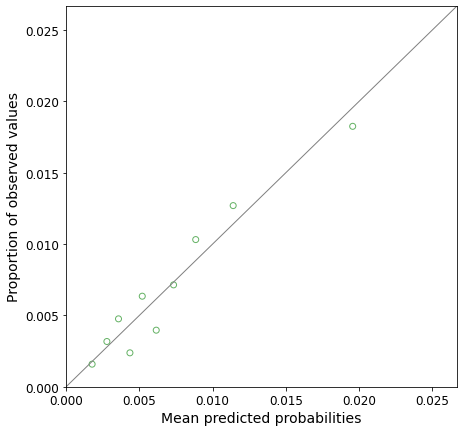

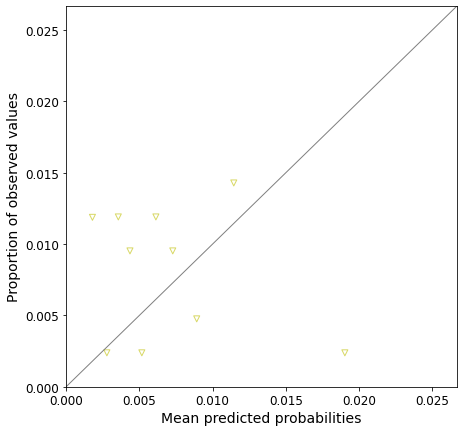

In [41]:
#data prep
data, data_urti_no_abs_prevl_enc = cox_data_prep(data_urti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'no_abs_prevl', data_urti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'no_abs_prevl', data_urti_no_abs_prevl)

try:
    #build cox model 
    cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test = cox_model_build('urti', 'no_abs_prevl', data_urti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_no_abs_prevl, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_no_abs_prevl.csv', data_urti_no_abs_prevl_enc, data_urti_no_abs_prevl, 'sum_betas_cph_urti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_no_abs_prevl, 'event_urti_admitted', data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, 'event_urti_admitted', data_urti_no_abs_prevl_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_no_abs_prevl_train.jpg', 'calibration_cph_urti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_no_abs_prevl, 'urti', 'no_abs_prevl', data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent urti with antibiotics

<lifelines.CoxPHFitter: fitted with 1424 total observations, 1413 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1424
number of events observed = 11
   partial log-likelihood = -53.12
         time fit was run = 2023-03-27 16:50:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.32       0.72       0.93            -2.15             1.50                 0.12                 4.50
CCI_cat[T.medium]               -0.15       0.86       1.06            -2.23             1.93                 0.11                 6.87
CCI_cat[T.high]                 -0.79       0.45       1.34            -3.42             1.83                 0.03                 6.22
CCI_cat[T.very_high]            -0.47       0.62       1.42            -3.26             2.31                 0.04                10.06
age_cat[T.25_34]                 0.05       1.05       1.16            -2.23             2.32                 0.11                10.21
age_cat[T.35_44]                -0.27       0.77       1.10            -2.42             1.89                 0.09                 6.61
age_cat[T.45_54]                -1.05       0.35       1.38            -3.75             1.64                 0.02                 5.17
age_cat[T.55_64]               -19.05       0.00    6199.79        -12170.43         12132.32                 0.00                  inf
age_cat[T.65_74]                -1.17       0.31       1.23            -3.58             1.24                 0.03                 3.47
age_cat[T.75_more]              -0.61       0.54       1.40            -3.36             2.14                 0.03                 8.52
antibacterial_brit              -0.60       0.55       0.35            -1.28             0.08                 0.28                 1.08
bmi_cat[T.obese]                 0.46       1.59       1.20            -1.89             2.82                 0.15                16.75
bmi_cat[T.overweight]          -18.19       0.00    6903.58        -13548.96         13512.58                 0.00                  inf
bmi_cat[T.underweight]           1.90       6.70       1.73            -1.49             5.29                 0.23               198.25
bmi_cat[T.unknown]              -0.74       0.48       1.53            -3.74             2.26                 0.02                 9.57
ethnicity[T.unknown]            -0.26       0.77       0.92            -2.06             1.53                 0.13                 4.62
ethnicity[T.white]              -2.47       0.08       1.05            -4.54            -0.41                 0.01                 0.67
flu_vaccine[T.yes]               0.22       1.25       1.19            -2.12             2.56                 0.12                12.96
imd[T.medium]                   -0.51       0.60       1.38            -3.22             2.20                 0.04                 9.02
imd[T.unaffluent]               -0.19       0.83       1.12            -2.38             2.00                 0.09                 7.42
imd[T.unknown]                   2.62      13.79       1.11             0.46             4.79                 1.58               120.31
imd[T.very_affluent]             0.77       2.16       1.05            -1.28             2.82                 0.28                16.76
imd[T.very_unaffluent]         -19.60       0.00   10776.12        -21140.41         21101.20                 0.00                  inf
region[T.east_midlands]          0.81       2.24       1.38            -1.90             3.51                 0.15                33.48
region[T.london]                 1.14       3.12       1.26            -1.

12876


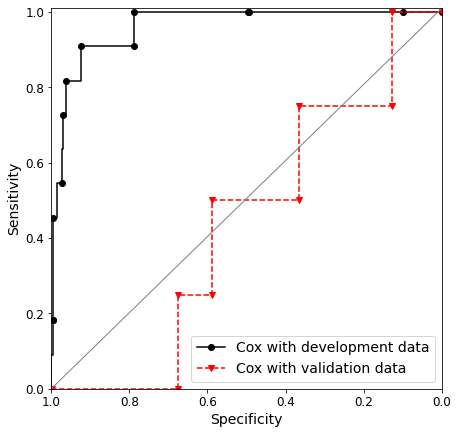

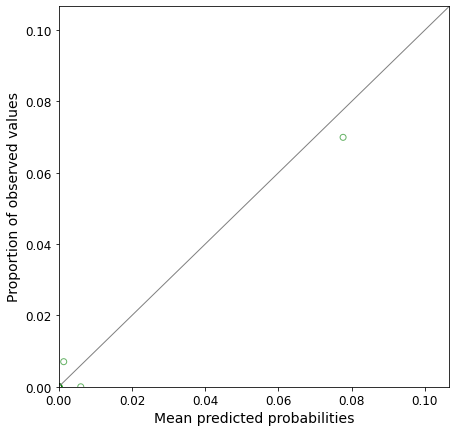

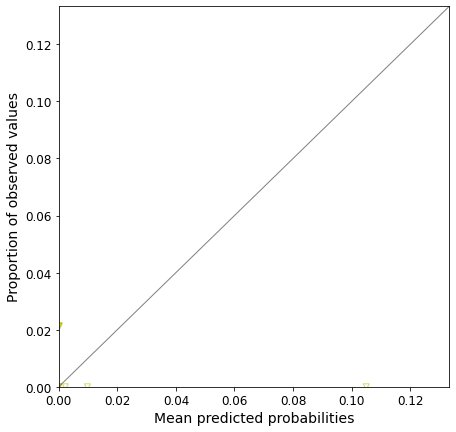

In [42]:
#data prep
data, data_urti_abs_prevl_enc = cox_data_prep(data_urti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'abs_prevl', data_urti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'abs_prevl', data_urti_abs_prevl)

try:
    #build cox model 
    cph_urti_abs_prevl, data_urti_abs_prevl_train, data_urti_abs_prevl_test = cox_model_build('urti', 'abs_prevl', data_urti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_abs_prevl, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_abs_prevl.csv', data_urti_abs_prevl_enc, data_urti_abs_prevl, 'sum_betas_cph_urti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_abs_prevl, 'event_urti_admitted', data_urti_abs_prevl_train, data_urti_abs_prevl_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_abs_prevl, data_urti_abs_prevl_train, 'event_urti_admitted', data_urti_abs_prevl_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_abs_prevl_train.jpg', 'calibration_cph_urti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_abs_prevl, 'urti', 'abs_prevl', data_urti_abs_prevl_train, data_urti_abs_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident urti

In [43]:
#data prep
data, data_urti_incdt_enc = cox_data_prep(data_urti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary tables from preped data
make_summary_table('urti', 'incdt', data_urti_incdt_enc)
make_summary_table_hosped('urti', 'incdt', data_urti_incdt)

try:
    cph_urti_incdt, data_urti_incdt_train, data_urti_incdt_test = cox_model_abs_build('urti', 'incdt', data_urti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt, 'urti', 'incdt', data_urti_incdt_train, data_urti_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125083 total observations, 124129 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 125083
number of events observed = 954
   partial log-likelihood = -11166.77
         time fit was run = 2023-03-27 16:50:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.16       1.18       0.10            -0.03             0.35                 0.97                 1.42
CCI_cat[T.medium]                0.04       1.05       0.11            -0.17             0.26                 0.85                 1.29
CCI_cat[T.high]                 -0.11       0.90       0.14            -0.38             0.16                 0.69                 1.17
CCI_cat[T.very_high]            -0.01       0.99       0.12            -0.24             0.21                 0.79                 1.24
age_cat[T.25_34]                -0.04       0.96       0.12            -0.28             0.19                 0.76                 1.21
age_cat[T.35_44]                -0.07       0.93       0.12            -0.31             0.16                 0.74                 1.18
age_cat[T.45_54]                -0.05       0.95       0.12            -0.28             0.19                 0.76                 1.21
age_cat[T.55_64]                -0.05       0.95       0.12            -0.28             0.19                 0.75                 1.20
age_cat[T.65_74]                -0.19       0.83       0.12            -0.43             0.06                 0.65                 1.06
age_cat[T.75_more]              -0.08       0.92       0.12            -0.31             0.15                 0.73                 1.17
antibacterial_brit               0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
bmi_cat[T.obese]                 0.25       1.28       0.13            -0.01             0.51                 0.99                 1.67
bmi_cat[T.overweight]            0.11       1.11       0.16            -0.21             0.42                 0.81                 1.53
bmi_cat[T.underweight]           0.24       1.27       0.22            -0.19             0.66                 0.83                 1.94
bmi_cat[T.unknown]               0.22       1.25       0.14            -0.05             0.50                 0.95                 1.65
ethnicity[T.unknown]            -0.03       0.97       0.11            -0.25             0.18                 0.78                 1.20
ethnicity[T.white]               0.17       1.19       0.10            -0.01             0.36                 0.99                 1.44
flu_vaccine[T.yes]              -0.14       0.87       0.11            -0.36             0.09                 0.70                 1.09
imd[T.medium]                    0.12       1.12       0.10            -0.09             0.32                 0.92                 1.37
imd[T.unaffluent]               -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.17
imd[T.unknown]                  -0.16       0.85       0.17            -0.50             0.18                 0.61                 1.20
imd[T.very_affluent]            -0.01       0.99       0.11            -0.22             0.20                 0.80                 1.22
imd[T.very_unaffluent]           0.01       1.01       0.10            -0.20             0.21                 0.82                 1.24
region[T.east_midlands]          0.16       1.18       0.15            -0.13             0.46                 0.88                 1.58
region[T.london]                 0.10       1.11       0.13     

13037


### 5-6- hospital admission related to prevalent urti

In [44]:
#data prep
data, data_urti_prevl_enc = cox_data_prep(data_urti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary tables from preped data
make_summary_table('urti', 'prevl', data_urti_prevl_enc)
make_summary_table_hosped('urti', 'prevl', data_urti_prevl)

try:
    cph_urti_prevl, data_urti_prevl_train, data_urti_prevl_test = cox_model_abs_build('urti', 'prevl', data_urti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl, 'urti', 'prevl', data_urti_prevl_train, data_urti_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 14025 total observations, 13917 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 14025
number of events observed = 108
   partial log-likelihood = -1015.76
         time fit was run = 2023-03-27 16:50:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.30       0.74       0.26            -0.81             0.21                 0.44                 1.23
CCI_cat[T.medium]               -0.55       0.58       0.31            -1.16             0.07                 0.31                 1.07
CCI_cat[T.high]                 -0.39       0.68       0.38            -1.12             0.35                 0.32                 1.42
CCI_cat[T.very_high]            -0.41       0.66       0.32            -1.04             0.21                 0.35                 1.23
age_cat[T.25_34]                 0.27       1.31       0.31            -0.34             0.88                 0.71                 2.42
age_cat[T.35_44]                -0.19       0.83       0.34            -0.86             0.48                 0.42                 1.62
age_cat[T.45_54]                -0.26       0.77       0.36            -0.96             0.44                 0.38                 1.55
age_cat[T.55_64]                -0.81       0.44       0.43            -1.65             0.02                 0.19                 1.02
age_cat[T.65_74]                -0.75       0.47       0.41            -1.55             0.05                 0.21                 1.06
age_cat[T.75_more]               0.03       1.03       0.33            -0.61             0.68                 0.54                 1.97
antibacterial_brit              -0.00       1.00       0.07            -0.14             0.13                 0.87                 1.14
bmi_cat[T.obese]                -0.02       0.98       0.38            -0.77             0.72                 0.46                 2.06
bmi_cat[T.overweight]            0.20       1.22       0.44            -0.66             1.06                 0.52                 2.89
bmi_cat[T.underweight]           0.37       1.44       0.57            -0.75             1.49                 0.47                 4.42
bmi_cat[T.unknown]               0.06       1.06       0.40            -0.73             0.85                 0.48                 2.33
ethnicity[T.unknown]             0.03       1.03       0.31            -0.58             0.63                 0.56                 1.88
ethnicity[T.white]              -0.03       0.97       0.27            -0.57             0.51                 0.57                 1.66
flu_vaccine[T.yes]               0.19       1.20       0.30            -0.40             0.77                 0.67                 2.15
imd[T.medium]                    0.62       1.85       0.34            -0.06             1.29                 0.94                 3.65
imd[T.unaffluent]                0.37       1.45       0.36            -0.34             1.08                 0.71                 2.93
imd[T.unknown]                   0.49       1.63       0.49            -0.48             1.46                 0.62                 4.29
imd[T.very_affluent]             0.52       1.68       0.35            -0.17             1.20                 0.84                 3.34
imd[T.very_unaffluent]           0.57       1.77       0.34            -0.10             1.25                 0.90                 3.49
region[T.east_midlands]         -0.12       0.89       0.41            -0.92             0.68                 0.40                 1.98
region[T.london]                -0.08       0.93       0.34         

13050


### 5-7- hospital admission related to incident urti with prescribed antibiotics categories

In [45]:
#data prep
data, data_urti_incdt_abs_enc = cox_data_prep(data_urti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_abs, data_urti_incdt_abs_train, data_urti_incdt_abs_test = cox_model_ab_type_build('urti', 'incdt_ab_type', data_urti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_abs, 'urti', 'incdt_abs', data_urti_incdt_abs_train, data_urti_incdt_abs_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125083 total observations, 124129 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 125083
number of events observed = 954
   partial log-likelihood = -11166.49
         time fit was run = 2023-03-27 16:50:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.16       1.18       0.10            -0.03             0.35                 0.97                 1.42
CCI_cat[T.medium]                0.04       1.05       0.11            -0.17             0.26                 0.85                 1.29
CCI_cat[T.high]                 -0.11       0.90       0.14            -0.38             0.16                 0.69                 1.17
CCI_cat[T.very_high]            -0.01       0.99       0.12            -0.24             0.21                 0.79                 1.24
ab_type_cat[T.Doxycycline]      -0.71       0.49       1.07            -2.81             1.38                 0.06                 3.98
ab_type_cat[T.no]               -0.21       0.81       0.38            -0.96             0.53                 0.38                 1.70
ab_type_cat[T.other]            -0.07       0.93       0.39            -0.84             0.70                 0.43                 2.01
age_cat[T.25_34]                -0.04       0.96       0.12            -0.28             0.19                 0.76                 1.21
age_cat[T.35_44]                -0.07       0.93       0.12            -0.31             0.16                 0.74                 1.18
age_cat[T.45_54]                -0.05       0.95       0.12            -0.28             0.19                 0.76                 1.21
age_cat[T.55_64]                -0.05       0.95       0.12            -0.28             0.18                 0.75                 1.20
age_cat[T.65_74]                -0.19       0.83       0.12            -0.43             0.06                 0.65                 1.06
age_cat[T.75_more]              -0.08       0.92       0.12            -0.31             0.15                 0.73                 1.17
antibacterial_brit               0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
bmi_cat[T.obese]                 0.25       1.29       0.13            -0.01             0.51                 0.99                 1.67
bmi_cat[T.overweight]            0.11       1.11       0.16            -0.21             0.42                 0.81                 1.53
bmi_cat[T.underweight]           0.24       1.27       0.22            -0.19             0.66                 0.83                 1.94
bmi_cat[T.unknown]               0.22       1.25       0.14            -0.05             0.50                 0.95                 1.65
ethnicity[T.unknown]            -0.03       0.97       0.11            -0.25             0.18                 0.78                 1.20
ethnicity[T.white]               0.17       1.19       0.10            -0.01             0.36                 0.99                 1.44
flu_vaccine[T.yes]              -0.14       0.87       0.11            -0.36             0.09                 0.70                 1.09
imd[T.medium]                    0.12       1.12       0.10            -0.08             0.32                 0.92                 1.37
imd[T.unaffluent]               -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.17
imd[T.unknown]                  -0.16       0.85       0.17            -0.50             0.18                 0.61                 1.20
imd[T.very_affluent]            -0.01       0.99       0.11     

13606


### 5-8- hospital admission related to prevalent urti with prescribed antibiotics categories

In [46]:
#data prep
data, data_urti_prevl_abs_enc = cox_data_prep(data_urti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_abs, data_urti_prevl_abs_train, data_urti_prevl_abs_test = cox_model_ab_type_build('urti', 'prevl_ab_type', data_urti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_abs, 'urti', 'prevl_abs', data_urti_prevl_abs_train, data_urti_prevl_abs_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 14025 total observations, 13917 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 14025
number of events observed = 108
   partial log-likelihood = -1014.78
         time fit was run = 2023-03-27 16:50:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.31       0.73       0.26            -0.82             0.20                 0.44                 1.22
CCI_cat[T.medium]               -0.55       0.58       0.31            -1.16             0.06                 0.31                 1.06
CCI_cat[T.high]                 -0.38       0.68       0.38            -1.12             0.36                 0.33                 1.43
CCI_cat[T.very_high]            -0.42       0.66       0.32            -1.04             0.20                 0.35                 1.23
ab_type_cat[T.Doxycycline]       0.07       1.08    3769.56         -7388.13          7388.28                 0.00                  inf
ab_type_cat[T.no]               14.79   2.66e+06    2018.60         -3941.60          3971.18                 0.00                  inf
ab_type_cat[T.other]            14.92   3.03e+06    2018.60         -3941.47          3971.32                 0.00                  inf
age_cat[T.25_34]                 0.27       1.31       0.31            -0.34             0.88                 0.71                 2.42
age_cat[T.35_44]                -0.19       0.82       0.34            -0.87             0.48                 0.42                 1.62
age_cat[T.45_54]                -0.26       0.77       0.36            -0.96             0.44                 0.38                 1.55
age_cat[T.55_64]                -0.81       0.44       0.43            -1.65             0.02                 0.19                 1.02
age_cat[T.65_74]                -0.75       0.47       0.41            -1.55             0.05                 0.21                 1.06
age_cat[T.75_more]               0.03       1.03       0.33            -0.62             0.68                 0.54                 1.97
antibacterial_brit              -0.00       1.00       0.07            -0.14             0.13                 0.87                 1.14
bmi_cat[T.obese]                -0.02       0.98       0.38            -0.77             0.72                 0.46                 2.06
bmi_cat[T.overweight]            0.20       1.22       0.44            -0.66             1.06                 0.52                 2.88
bmi_cat[T.underweight]           0.36       1.44       0.57            -0.76             1.48                 0.47                 4.41
bmi_cat[T.unknown]               0.06       1.06       0.40            -0.73             0.84                 0.48                 2.32
ethnicity[T.unknown]             0.03       1.03       0.31            -0.58             0.63                 0.56                 1.88
ethnicity[T.white]              -0.03       0.97       0.27            -0.57             0.51                 0.57                 1.66
flu_vaccine[T.yes]               0.18       1.20       0.30            -0.40             0.76                 0.67                 2.14
imd[T.medium]                    0.62       1.86       0.34            -0.06             1.29                 0.94                 3.65
imd[T.unaffluent]                0.37       1.45       0.36            -0.34             1.08                 0.71                 2.94
imd[T.unknown]                   0.49       1.63       0.49            -0.48             1.46                 0.62                 4.29
imd[T.very_affluent]             0.52       1.68       0.35         

13647


### 5-9- stratified by sex
#### 5-9-1- incident males

In [47]:
#data prep
data, data_urti_incdt_males_enc = cox_data_prep(data_urti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_males, data_urti_incdt_males_train, data_urti_incdt_males_test = cox_model_strat_sex_build('urti', 'incdt_males', data_urti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_males, 'urti', 'incdt_males', data_urti_incdt_males_train, data_urti_incdt_males_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61180 total observations, 60751 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 61180
number of events observed = 429
   partial log-likelihood = -4705.31
         time fit was run = 2023-03-27 16:50:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.15       0.15            -0.14             0.43                 0.87                 1.54
CCI_cat[T.medium]                0.12       1.12       0.16            -0.20             0.43                 0.82                 1.54
CCI_cat[T.high]                 -0.06       0.94       0.20            -0.46             0.34                 0.63                 1.40
CCI_cat[T.very_high]             0.07       1.07       0.17            -0.27             0.40                 0.77                 1.50
age_cat[T.25_34]                 0.12       1.12       0.18            -0.23             0.46                 0.80                 1.59
age_cat[T.35_44]                -0.04       0.96       0.18            -0.40             0.32                 0.67                 1.37
age_cat[T.45_54]                 0.00       1.00       0.18            -0.36             0.36                 0.70                 1.43
age_cat[T.55_64]                -0.06       0.94       0.18            -0.42             0.30                 0.66                 1.35
age_cat[T.65_74]                 0.00       1.00       0.18            -0.35             0.36                 0.70                 1.43
age_cat[T.75_more]              -0.04       0.96       0.18            -0.40             0.32                 0.67                 1.38
antibacterial_brit              -0.01       0.99       0.03            -0.08             0.06                 0.93                 1.06
bmi_cat[T.obese]                 0.36       1.43       0.20            -0.04             0.75                 0.96                 2.13
bmi_cat[T.overweight]            0.35       1.42       0.24            -0.12             0.82                 0.89                 2.26
bmi_cat[T.underweight]           0.41       1.51       0.32            -0.21             1.03                 0.81                 2.81
bmi_cat[T.unknown]               0.28       1.32       0.22            -0.15             0.70                 0.86                 2.01
ethnicity[T.unknown]             0.09       1.09       0.17            -0.25             0.43                 0.78                 1.53
ethnicity[T.white]               0.28       1.33       0.15            -0.01             0.58                 0.99                 1.78
flu_vaccine[T.yes]              -0.17       0.84       0.17            -0.51             0.17                 0.60                 1.18
imd[T.medium]                    0.00       1.00       0.16            -0.30             0.31                 0.74                 1.36
imd[T.unaffluent]               -0.13       0.88       0.16            -0.45             0.19                 0.64                 1.20
imd[T.unknown]                   0.02       1.02       0.24            -0.44             0.48                 0.64                 1.62
imd[T.very_affluent]             0.07       1.07       0.15            -0.23             0.37                 0.79                 1.44
imd[T.very_unaffluent]          -0.04       0.97       0.16            -0.34             0.27                 0.71                 1.31
region[T.east_midlands]          0.37       1.45       0.23            -0.07             0.82                 0.93                 2.27
region[T.london]                 0.22       1.24       0.21         

12760


#### 5-9-2- incident females

In [48]:
#data prep
data, data_urti_incdt_females_enc = cox_data_prep(data_urti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_females, data_urti_incdt_females_train, data_urti_incdt_females_test = cox_model_strat_sex_build('urti', 'incdt_females', data_urti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_females, 'urti', 'incdt_females', data_urti_incdt_females_train, data_urti_incdt_females_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 63903 total observations, 63421 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 63903
number of events observed = 482
   partial log-likelihood = -5314.35
         time fit was run = 2023-03-27 16:51:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.29       0.14            -0.02             0.53                 0.98                 1.69
CCI_cat[T.medium]                0.01       1.01       0.16            -0.29             0.32                 0.75                 1.38
CCI_cat[T.high]                 -0.04       0.96       0.19            -0.42             0.34                 0.66                 1.41
CCI_cat[T.very_high]            -0.01       0.99       0.17            -0.33             0.32                 0.72                 1.38
age_cat[T.25_34]                -0.07       0.93       0.17            -0.39             0.25                 0.67                 1.29
age_cat[T.35_44]                -0.22       0.80       0.17            -0.56             0.11                 0.57                 1.12
age_cat[T.45_54]                -0.03       0.97       0.16            -0.35             0.29                 0.71                 1.34
age_cat[T.55_64]                -0.11       0.90       0.17            -0.43             0.22                 0.65                 1.25
age_cat[T.65_74]                -0.26       0.77       0.17            -0.60             0.08                 0.55                 1.08
age_cat[T.75_more]              -0.09       0.91       0.16            -0.41             0.23                 0.66                 1.26
antibacterial_brit              -0.04       0.97       0.03            -0.10             0.03                 0.91                 1.03
bmi_cat[T.obese]                 0.30       1.35       0.19            -0.07             0.67                 0.93                 1.95
bmi_cat[T.overweight]            0.13       1.13       0.23            -0.32             0.57                 0.72                 1.78
bmi_cat[T.underweight]           0.31       1.36       0.30            -0.28             0.90                 0.75                 2.46
bmi_cat[T.unknown]               0.12       1.12       0.20            -0.28             0.52                 0.76                 1.68
ethnicity[T.unknown]             0.07       1.08       0.15            -0.22             0.37                 0.80                 1.45
ethnicity[T.white]               0.09       1.09       0.13            -0.18             0.35                 0.84                 1.42
flu_vaccine[T.yes]              -0.14       0.87       0.16            -0.46             0.17                 0.63                 1.19
imd[T.medium]                   -0.07       0.93       0.15            -0.36             0.22                 0.70                 1.24
imd[T.unaffluent]               -0.01       0.99       0.14            -0.29             0.28                 0.75                 1.32
imd[T.unknown]                  -0.14       0.87       0.24            -0.60             0.32                 0.55                 1.38
imd[T.very_affluent]            -0.10       0.91       0.15            -0.39             0.19                 0.68                 1.21
imd[T.very_unaffluent]          -0.16       0.85       0.15            -0.45             0.13                 0.64                 1.14
region[T.east_midlands]          0.11       1.12       0.21            -0.30             0.52                 0.74                 1.69
region[T.london]                 0.11       1.12       0.19         

12768


#### 5-9-3- prevalent males

In [49]:
#data prep
data, data_urti_prevl_males_enc = cox_data_prep(data_urti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_males, data_urti_prevl_males_train, data_urti_prevl_males_test = cox_model_strat_sex_build('urti', 'prevl_males', data_urti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_urti_prevl_males, 'urti', 'prevl_males', data_urti_prevl_males_train, data_urti_prevl_males_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6939 total observations, 6886 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 6939
number of events observed = 53
   partial log-likelihood = -448.28
         time fit was run = 2023-03-27 16:51:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.46       0.63       0.38            -1.20             0.29                 0.30                 1.33
CCI_cat[T.medium]               -0.43       0.65       0.43            -1.27             0.42                 0.28                 1.52
CCI_cat[T.high]                 -0.75       0.47       0.58            -1.88             0.39                 0.15                 1.47
CCI_cat[T.very_high]            -0.27       0.77       0.43            -1.11             0.58                 0.33                 1.78
age_cat[T.25_34]                 0.30       1.36       0.48            -0.63             1.24                 0.53                 3.45
age_cat[T.35_44]                 0.30       1.34       0.47            -0.62             1.21                 0.54                 3.37
age_cat[T.45_54]                -0.56       0.57       0.61            -1.76             0.64                 0.17                 1.90
age_cat[T.55_64]                -0.45       0.64       0.57            -1.57             0.67                 0.21                 1.96
age_cat[T.65_74]                -0.24       0.79       0.54            -1.30             0.83                 0.27                 2.29
age_cat[T.75_more]               0.21       1.24       0.49            -0.75             1.17                 0.47                 3.22
antibacterial_brit               0.10       1.10       0.09            -0.09             0.28                 0.92                 1.32
bmi_cat[T.obese]                 0.80       2.23       0.73            -0.63             2.24                 0.53                 9.35
bmi_cat[T.overweight]            0.51       1.66       0.84            -1.14             2.15                 0.32                 8.60
bmi_cat[T.underweight]           1.15       3.14       0.92            -0.65             2.94                 0.52                19.00
bmi_cat[T.unknown]               0.66       1.94       0.76            -0.83             2.15                 0.44                 8.62
ethnicity[T.unknown]            -0.54       0.58       0.41            -1.35             0.26                 0.26                 1.30
ethnicity[T.white]              -0.52       0.59       0.35            -1.20             0.16                 0.30                 1.17
flu_vaccine[T.yes]               0.39       1.48       0.39            -0.37             1.15                 0.69                 3.16
imd[T.medium]                    0.45       1.56       0.45            -0.44             1.33                 0.65                 3.79
imd[T.unaffluent]               -0.15       0.86       0.52            -1.17             0.87                 0.31                 2.38
imd[T.unknown]                  -0.14       0.87       0.79            -1.69             1.42                 0.18                 4.12
imd[T.very_affluent]             0.41       1.51       0.46            -0.49             1.31                 0.61                 3.70
imd[T.very_unaffluent]           0.20       1.22       0.47            -0.72             1.11                 0.49                 3.04
region[T.east_midlands]          1.59       4.91       0.78             0.06             3.13                 1.06                22.79
region[T.london]                 1.08       2.94       0.77            -0

12766


#### 5-9-4- prevalent females

In [50]:
try:
    #data prep
    data, data_urti_prevl_females_enc = cox_data_prep(data_urti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

    #cox model
    cph_urti_prevl_females, data_urti_prevl_females_train, data_urti_prevl_females_test = cox_model_strat_sex_build('urti', 'prevl_females', data_urti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_females, 'urti', 'prevl_females', data_urti_prevl_females_train, data_urti_prevl_females_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7085 total observations, 7035 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 7085
number of events observed = 50
   partial log-likelihood = -425.66
         time fit was run = 2023-03-27 16:51:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.21       0.81       0.36            -0.92             0.50                 0.40                 1.65
CCI_cat[T.medium]               -0.80       0.45       0.48            -1.74             0.13                 0.18                 1.14
CCI_cat[T.high]                 -0.62       0.54       0.58            -1.75             0.52                 0.17                 1.68
CCI_cat[T.very_high]            -0.96       0.38       0.53            -2.01             0.09                 0.13                 1.09
age_cat[T.25_34]                 0.56       1.75       0.47            -0.36             1.48                 0.70                 4.40
age_cat[T.35_44]                -0.20       0.82       0.56            -1.29             0.89                 0.27                 2.44
age_cat[T.45_54]                -0.85       0.43       0.69            -2.20             0.51                 0.11                 1.66
age_cat[T.55_64]                -0.86       0.42       0.69            -2.21             0.50                 0.11                 1.65
age_cat[T.65_74]                -0.07       0.93       0.54            -1.12             0.98                 0.33                 2.67
age_cat[T.75_more]               0.45       1.57       0.49            -0.50             1.40                 0.60                 4.07
antibacterial_brit               0.03       1.04       0.10            -0.16             0.23                 0.85                 1.26
bmi_cat[T.obese]                 0.63       1.88       0.74            -0.81             2.07                 0.44                 7.95
bmi_cat[T.overweight]            0.93       2.53       0.79            -0.62             2.48                 0.54                11.96
bmi_cat[T.underweight]           0.80       2.22       1.00            -1.17             2.76                 0.31                15.83
bmi_cat[T.unknown]               0.55       1.74       0.77            -0.95             2.05                 0.39                 7.79
ethnicity[T.unknown]             0.02       1.02       0.46            -0.88             0.92                 0.42                 2.52
ethnicity[T.white]               0.00       1.00       0.40            -0.78             0.79                 0.46                 2.19
flu_vaccine[T.yes]               0.01       1.01       0.47            -0.92             0.94                 0.40                 2.56
imd[T.medium]                    0.38       1.47       0.47            -0.53             1.30                 0.59                 3.66
imd[T.unaffluent]                0.22       1.25       0.48            -0.71             1.16                 0.49                 3.18
imd[T.unknown]                   0.50       1.65       0.62            -0.71             1.71                 0.49                 5.55
imd[T.very_affluent]             0.29       1.34       0.48            -0.64             1.23                 0.53                 3.41
imd[T.very_unaffluent]          -0.15       0.86       0.52            -1.17             0.86                 0.31                 2.37
region[T.east_midlands]         -1.09       0.34       0.67            -2.40             0.22                 0.09                 1.25
region[T.london]                -0.40       0.67       0.44            -1

12775


### 5-10- stratified by age category
#### 5-10-1- incident

In [51]:
#data prep
data, data_urti_incdt_15_24_enc = cox_data_prep(data_urti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_15_24, data_urti_incdt_15_24_train, data_urti_incdt_15_24_test = cox_model_strat_age_build('urti', 'incdt_15_24', data_urti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_15_24, 'urti', 'incdt_15_24', data_urti_incdt_15_24_train, data_urti_incdt_15_24_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17788 total observations, 17648 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17788
number of events observed = 140
   partial log-likelihood = -1353.44
         time fit was run = 2023-03-27 16:51:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.20       0.25            -0.30             0.66                 0.74                 1.94
CCI_cat[T.medium]               -0.25       0.78       0.30            -0.83             0.33                 0.44                 1.39
CCI_cat[T.high]                 -0.50       0.61       0.39            -1.27             0.27                 0.28                 1.31
CCI_cat[T.very_high]             0.11       1.12       0.29            -0.45             0.68                 0.64                 1.97
antibacterial_brit              -0.02       0.98       0.06            -0.13             0.10                 0.88                 1.11
bmi_cat[T.obese]                 0.02       1.02       0.31            -0.59             0.63                 0.56                 1.88
bmi_cat[T.overweight]           -0.10       0.90       0.39            -0.86             0.66                 0.42                 1.93
bmi_cat[T.underweight]          -0.17       0.84       0.58            -1.30             0.96                 0.27                 2.62
bmi_cat[T.unknown]              -0.19       0.83       0.34            -0.85             0.48                 0.43                 1.62
ethnicity[T.unknown]            -0.23       0.80       0.26            -0.75             0.29                 0.47                 1.34
ethnicity[T.white]              -0.18       0.83       0.23            -0.62             0.26                 0.54                 1.30
flu_vaccine[T.yes]               0.14       1.15       0.27            -0.38             0.66                 0.68                 1.94
imd[T.medium]                    0.23       1.26       0.25            -0.25             0.72                 0.78                 2.06
imd[T.unaffluent]               -0.07       0.93       0.27            -0.60             0.47                 0.55                 1.60
imd[T.unknown]                  -0.20       0.82       0.42            -1.03             0.62                 0.36                 1.86
imd[T.very_affluent]            -0.33       0.72       0.29            -0.89             0.23                 0.41                 1.26
imd[T.very_unaffluent]          -0.32       0.73       0.29            -0.88             0.24                 0.41                 1.28
region[T.east_midlands]          0.47       1.60       0.41            -0.33             1.27                 0.72                 3.56
region[T.london]                 0.30       1.35       0.37            -0.43             1.03                 0.65                 2.80
region[T.north_east]             0.40       1.49       0.41            -0.40             1.20                 0.67                 3.33
region[T.north_west]             0.45       1.57       0.41            -0.36             1.26                 0.70                 3.54
region[T.south_east]             0.32       1.38       0.41            -0.49             1.13                 0.61                 3.11
region[T.south_west]             0.60       1.83       0.40            -0.18             1.38                 0.84                 3.99
region[T.west_midlands]          0.62       1.87       0.40            -0.15             1.40                 0.86                 4.05
region[T.yorkshire]              0.16       1.17       0.44         

11400


In [52]:
#data prep
data, data_urti_incdt_25_34_enc = cox_data_prep(data_urti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_25_34, data_urti_incdt_25_34_train, data_urti_incdt_25_34_test = cox_model_strat_age_build('urti', 'incdt_25_34', data_urti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_25_34, 'urti', 'incdt_25_34', data_urti_incdt_25_34_train, data_urti_incdt_25_34_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17775 total observations, 17642 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17775
number of events observed = 133
   partial log-likelihood = -1286.10
         time fit was run = 2023-03-27 16:51:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.62       1.85       0.29             0.05             1.18                 1.05                 3.27
CCI_cat[T.medium]                0.58       1.78       0.31            -0.03             1.19                 0.97                 3.28
CCI_cat[T.high]                  0.26       1.30       0.39            -0.50             1.02                 0.61                 2.77
CCI_cat[T.very_high]            -0.04       0.96       0.37            -0.76             0.68                 0.47                 1.97
antibacterial_brit              -0.06       0.94       0.06            -0.18             0.06                 0.83                 1.07
bmi_cat[T.obese]                 0.22       1.24       0.34            -0.44             0.87                 0.64                 2.40
bmi_cat[T.overweight]           -0.03       0.97       0.42            -0.86             0.80                 0.42                 2.22
bmi_cat[T.underweight]           0.01       1.02       0.59            -1.15             1.18                 0.32                 3.24
bmi_cat[T.unknown]              -0.24       0.78       0.37            -0.97             0.49                 0.38                 1.63
ethnicity[T.unknown]             0.59       1.80       0.31            -0.03             1.20                 0.97                 3.31
ethnicity[T.white]               0.42       1.52       0.29            -0.15             0.98                 0.86                 2.67
flu_vaccine[T.yes]               0.23       1.26       0.26            -0.28             0.74                 0.76                 2.10
imd[T.medium]                   -0.07       0.93       0.27            -0.59             0.45                 0.55                 1.56
imd[T.unaffluent]               -0.24       0.79       0.28            -0.78             0.31                 0.46                 1.36
imd[T.unknown]                  -0.71       0.49       0.53            -1.75             0.33                 0.17                 1.40
imd[T.very_affluent]            -0.04       0.96       0.26            -0.55             0.47                 0.58                 1.61
imd[T.very_unaffluent]          -0.45       0.63       0.29            -1.02             0.11                 0.36                 1.12
region[T.east_midlands]          0.38       1.46       0.47            -0.53             1.29                 0.59                 3.64
region[T.london]                 0.69       1.99       0.40            -0.09             1.47                 0.91                 4.35
region[T.north_east]             0.40       1.49       0.47            -0.51             1.31                 0.60                 3.71
region[T.north_west]             0.58       1.78       0.45            -0.30             1.46                 0.74                 4.31
region[T.south_east]             0.70       2.00       0.44            -0.16             1.55                 0.85                 4.73
region[T.south_west]             0.61       1.85       0.44            -0.25             1.48                 0.78                 4.41
region[T.west_midlands]          0.72       2.06       0.43            -0.13             1.57                 0.88                 4.81
region[T.yorkshire]              0.63       1.88       0.44         

11393


In [53]:
#data prep
data, data_urti_incdt_35_44_enc = cox_data_prep(data_urti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_35_44, data_urti_incdt_35_44_train, data_urti_incdt_35_44_test = cox_model_strat_age_build('urti', 'incdt_35_44', data_urti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_35_44, 'urti', 'incdt_35_44', data_urti_incdt_35_44_train, data_urti_incdt_35_44_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17895 total observations, 17764 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17895
number of events observed = 131
   partial log-likelihood = -1268.28
         time fit was run = 2023-03-27 16:51:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.25            -0.48             0.51                 0.62                 1.67
CCI_cat[T.medium]               -0.27       0.76       0.30            -0.85             0.31                 0.43                 1.36
CCI_cat[T.high]                 -0.19       0.83       0.36            -0.89             0.51                 0.41                 1.67
CCI_cat[T.very_high]            -0.04       0.96       0.30            -0.62             0.54                 0.54                 1.72
antibacterial_brit              -0.02       0.98       0.06            -0.14             0.10                 0.87                 1.11
bmi_cat[T.obese]                 0.37       1.45       0.37            -0.36             1.11                 0.70                 3.02
bmi_cat[T.overweight]            0.36       1.44       0.44            -0.50             1.22                 0.61                 3.40
bmi_cat[T.underweight]           0.70       2.02       0.54            -0.36             1.76                 0.70                 5.84
bmi_cat[T.unknown]               0.28       1.33       0.40            -0.50             1.06                 0.61                 2.89
ethnicity[T.unknown]             0.25       1.28       0.28            -0.30             0.80                 0.74                 2.23
ethnicity[T.white]              -0.01       0.99       0.26            -0.52             0.49                 0.59                 1.63
flu_vaccine[T.yes]              -0.10       0.90       0.30            -0.69             0.50                 0.50                 1.64
imd[T.medium]                   -0.60       0.55       0.31            -1.21             0.01                 0.30                 1.01
imd[T.unaffluent]               -0.01       0.99       0.26            -0.53             0.50                 0.59                 1.65
imd[T.unknown]                   0.17       1.19       0.38            -0.58             0.92                 0.56                 2.52
imd[T.very_affluent]            -0.18       0.84       0.28            -0.73             0.37                 0.48                 1.45
imd[T.very_unaffluent]          -0.17       0.84       0.27            -0.71             0.36                 0.49                 1.43
region[T.east_midlands]         -0.04       0.96       0.36            -0.74             0.67                 0.48                 1.95
region[T.london]                -0.35       0.71       0.33            -0.99             0.29                 0.37                 1.34
region[T.north_east]            -0.85       0.43       0.45            -1.74             0.04                 0.18                 1.04
region[T.north_west]            -0.39       0.68       0.39            -1.15             0.38                 0.32                 1.47
region[T.south_east]             0.22       1.25       0.34            -0.44             0.88                 0.65                 2.41
region[T.south_west]            -0.73       0.48       0.43            -1.58             0.12                 0.21                 1.12
region[T.west_midlands]          0.02       1.02       0.35            -0.67             0.71                 0.51                 2.04
region[T.yorkshire]             -0.10       0.91       0.36         

11408


In [54]:
#data prep
data, data_urti_incdt_45_54_enc = cox_data_prep(data_urti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_45_54, data_urti_incdt_45_54_train, data_urti_incdt_45_54_test = cox_model_strat_age_build('urti', 'incdt_45_54', data_urti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_45_54, 'urti', 'incdt_45_54', data_urti_incdt_45_54_train, data_urti_incdt_45_54_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17731 total observations, 17598 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17731
number of events observed = 133
   partial log-likelihood = -1280.99
         time fit was run = 2023-03-27 16:51:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.10       0.25            -0.41             0.59                 0.67                 1.81
CCI_cat[T.medium]               -0.20       0.82       0.30            -0.78             0.38                 0.46                 1.46
CCI_cat[T.high]                  0.14       1.15       0.34            -0.52             0.79                 0.59                 2.21
CCI_cat[T.very_high]            -0.19       0.83       0.31            -0.80             0.42                 0.45                 1.52
antibacterial_brit              -0.09       0.92       0.06            -0.21             0.04                 0.81                 1.04
bmi_cat[T.obese]                -0.04       0.96       0.33            -0.68             0.60                 0.51                 1.83
bmi_cat[T.overweight]           -0.10       0.91       0.40            -0.89             0.69                 0.41                 2.00
bmi_cat[T.underweight]           0.68       1.98       0.45            -0.20             1.57                 0.82                 4.78
bmi_cat[T.unknown]              -0.06       0.94       0.35            -0.74             0.63                 0.48                 1.87
ethnicity[T.unknown]             0.71       2.03       0.33             0.06             1.36                 1.06                 3.89
ethnicity[T.white]               0.61       1.84       0.31             0.00             1.21                 1.00                 3.37
flu_vaccine[T.yes]               0.18       1.20       0.27            -0.34             0.70                 0.71                 2.02
imd[T.medium]                    0.03       1.03       0.27            -0.49             0.55                 0.61                 1.74
imd[T.unaffluent]               -0.14       0.87       0.28            -0.68             0.40                 0.51                 1.50
imd[T.unknown]                   0.32       1.37       0.38            -0.43             1.07                 0.65                 2.91
imd[T.very_affluent]            -0.16       0.85       0.28            -0.71             0.38                 0.49                 1.47
imd[T.very_unaffluent]          -0.36       0.70       0.29            -0.93             0.21                 0.39                 1.24
region[T.east_midlands]         -0.16       0.85       0.42            -0.98             0.66                 0.37                 1.93
region[T.london]                -0.12       0.89       0.36            -0.83             0.59                 0.44                 1.81
region[T.north_east]             0.01       1.01       0.40            -0.78             0.80                 0.46                 2.22
region[T.north_west]            -0.14       0.87       0.42            -0.96             0.68                 0.38                 1.97
region[T.south_east]             0.34       1.41       0.38            -0.40             1.08                 0.67                 2.95
region[T.south_west]             0.21       1.24       0.38            -0.54             0.96                 0.58                 2.62
region[T.west_midlands]         -0.15       0.86       0.43            -0.99             0.69                 0.37                 1.99
region[T.yorkshire]              0.58       1.79       0.36         

11399


In [55]:
#data prep
data, data_urti_incdt_55_64_enc = cox_data_prep(data_urti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_55_64, data_urti_incdt_55_64_train, data_urti_incdt_55_64_test = cox_model_strat_age_build('urti', 'incdt_55_64', data_urti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_55_64, 'urti', 'incdt_55_64', data_urti_incdt_55_64_train, data_urti_incdt_55_64_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17866 total observations, 17733 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17866
number of events observed = 133
   partial log-likelihood = -1284.54
         time fit was run = 2023-03-27 16:51:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.28       0.25            -0.24             0.73                 0.79                 2.08
CCI_cat[T.medium]               -0.09       0.91       0.29            -0.67             0.48                 0.51                 1.61
CCI_cat[T.high]                 -0.32       0.73       0.38            -1.06             0.42                 0.35                 1.53
CCI_cat[T.very_high]            -0.22       0.80       0.32            -0.84             0.39                 0.43                 1.48
antibacterial_brit               0.06       1.07       0.06            -0.05             0.18                 0.95                 1.20
bmi_cat[T.obese]                 0.26       1.29       0.35            -0.44             0.95                 0.65                 2.59
bmi_cat[T.overweight]           -0.25       0.78       0.46            -1.15             0.65                 0.32                 1.92
bmi_cat[T.underweight]          -0.55       0.57       0.78            -2.09             0.98                 0.12                 2.66
bmi_cat[T.unknown]               0.28       1.32       0.37            -0.45             1.00                 0.64                 2.73
ethnicity[T.unknown]            -0.06       0.95       0.33            -0.70             0.59                 0.50                 1.81
ethnicity[T.white]               0.45       1.57       0.28            -0.10             1.00                 0.91                 2.71
flu_vaccine[T.yes]               0.26       1.29       0.26            -0.25             0.77                 0.78                 2.15
imd[T.medium]                    0.17       1.19       0.28            -0.38             0.73                 0.68                 2.06
imd[T.unaffluent]               -0.09       0.92       0.30            -0.67             0.50                 0.51                 1.65
imd[T.unknown]                  -0.00       1.00       0.46            -0.90             0.90                 0.41                 2.45
imd[T.very_affluent]            -0.11       0.90       0.30            -0.69             0.48                 0.50                 1.61
imd[T.very_unaffluent]           0.31       1.36       0.27            -0.23             0.85                 0.80                 2.33
region[T.east_midlands]         -0.31       0.73       0.42            -1.14             0.51                 0.32                 1.67
region[T.london]                -0.02       0.98       0.34            -0.70             0.65                 0.50                 1.92
region[T.north_east]             0.21       1.23       0.37            -0.51             0.93                 0.60                 2.54
region[T.north_west]            -0.15       0.86       0.41            -0.96             0.65                 0.38                 1.92
region[T.south_east]             0.22       1.25       0.38            -0.52             0.97                 0.60                 2.63
region[T.south_west]             0.29       1.34       0.37            -0.43             1.02                 0.65                 2.76
region[T.west_midlands]         -0.17       0.84       0.41            -0.97             0.63                 0.38                 1.89
region[T.yorkshire]              0.16       1.18       0.38         

11404


In [56]:
#data prep
data, data_urti_incdt_65_74_enc = cox_data_prep(data_urti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_65_74, data_urti_incdt_65_74_train, data_urti_incdt_65_74_test = cox_model_strat_age_build('urti', 'incdt_65_74', data_urti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_65_74, 'urti', 'incdt_65_74', data_urti_incdt_65_74_train, data_urti_incdt_65_74_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17962 total observations, 17835 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17962
number of events observed = 127
   partial log-likelihood = -1227.13
         time fit was run = 2023-03-27 16:51:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.28            -0.57             0.52                 0.56                 1.68
CCI_cat[T.medium]                0.19       1.21       0.29            -0.39             0.76                 0.68                 2.15
CCI_cat[T.high]                 -0.06       0.94       0.38            -0.81             0.68                 0.45                 1.98
CCI_cat[T.very_high]             0.33       1.39       0.30            -0.26             0.92                 0.77                 2.51
antibacterial_brit              -0.01       0.99       0.06            -0.14             0.11                 0.87                 1.12
bmi_cat[T.obese]                 0.22       1.25       0.35            -0.48             0.92                 0.62                 2.50
bmi_cat[T.overweight]           -0.07       0.94       0.45            -0.95             0.82                 0.39                 2.26
bmi_cat[T.underweight]           0.62       1.87       0.53            -0.41             1.66                 0.66                 5.26
bmi_cat[T.unknown]               0.19       1.21       0.38            -0.55             0.93                 0.58                 2.55
ethnicity[T.unknown]            -0.49       0.62       0.35            -1.17             0.20                 0.31                 1.22
ethnicity[T.white]               0.35       1.42       0.27            -0.18             0.88                 0.84                 2.42
flu_vaccine[T.yes]              -0.07       0.94       0.30            -0.66             0.53                 0.52                 1.70
imd[T.medium]                   -0.34       0.71       0.28            -0.89             0.22                 0.41                 1.25
imd[T.unaffluent]               -0.17       0.84       0.27            -0.71             0.36                 0.49                 1.44
imd[T.unknown]                  -0.69       0.50       0.53            -1.74             0.36                 0.18                 1.43
imd[T.very_affluent]            -0.12       0.88       0.27            -0.65             0.40                 0.52                 1.49
imd[T.very_unaffluent]          -0.38       0.68       0.29            -0.95             0.19                 0.39                 1.21
region[T.east_midlands]          0.08       1.08       0.42            -0.74             0.89                 0.48                 2.45
region[T.london]                 0.14       1.15       0.36            -0.57             0.85                 0.57                 2.35
region[T.north_east]             0.18       1.19       0.41            -0.63             0.98                 0.53                 2.67
region[T.north_west]             0.15       1.16       0.41            -0.66             0.95                 0.52                 2.59
region[T.south_east]             0.28       1.32       0.40            -0.51             1.07                 0.60                 2.91
region[T.south_west]             0.15       1.16       0.42            -0.67             0.97                 0.51                 2.63
region[T.west_midlands]          0.21       1.23       0.41            -0.60             1.01                 0.55                 2.75
region[T.yorkshire]              0.28       1.32       0.40         

11401


In [57]:
#data prep
data, data_urti_incdt_75_more_enc = cox_data_prep(data_urti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_75_more, data_urti_incdt_75_more_train, data_urti_incdt_75_more_test = cox_model_strat_age_build('urti', 'incdt_75_more', data_urti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_75_more, 'urti', 'incdt_75_more', data_urti_incdt_75_more_train, data_urti_incdt_75_more_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18063 total observations, 17920 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 18063
number of events observed = 143
   partial log-likelihood = -1387.73
         time fit was run = 2023-03-27 16:51:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.28       0.28            -0.29             0.79                 0.75                 2.20
CCI_cat[T.medium]                0.42       1.53       0.29            -0.14             0.99                 0.87                 2.69
CCI_cat[T.high]                  0.46       1.58       0.33            -0.19             1.11                 0.82                 3.04
CCI_cat[T.very_high]             0.17       1.18       0.32            -0.46             0.80                 0.63                 2.22
antibacterial_brit               0.10       1.10       0.06            -0.01             0.21                 0.99                 1.23
bmi_cat[T.obese]                 0.03       1.03       0.32            -0.61             0.66                 0.55                 1.94
bmi_cat[T.overweight]            0.18       1.19       0.39            -0.58             0.93                 0.56                 2.55
bmi_cat[T.underweight]          -0.73       0.48       0.77            -2.24             0.78                 0.11                 2.18
bmi_cat[T.unknown]               0.17       1.19       0.34            -0.49             0.84                 0.61                 2.32
ethnicity[T.unknown]             0.15       1.17       0.28            -0.40             0.71                 0.67                 2.03
ethnicity[T.white]               0.16       1.17       0.25            -0.34             0.66                 0.71                 1.93
flu_vaccine[T.yes]              -0.25       0.78       0.31            -0.86             0.37                 0.42                 1.44
imd[T.medium]                   -0.14       0.87       0.30            -0.72             0.44                 0.49                 1.55
imd[T.unaffluent]                0.42       1.52       0.26            -0.10             0.93                 0.91                 2.54
imd[T.unknown]                   0.04       1.04       0.43            -0.80             0.88                 0.45                 2.42
imd[T.very_affluent]             0.12       1.13       0.28            -0.43             0.67                 0.65                 1.96
imd[T.very_unaffluent]           0.02       1.02       0.28            -0.54             0.57                 0.58                 1.77
region[T.east_midlands]          0.05       1.06       0.36            -0.65             0.76                 0.52                 2.14
region[T.london]                -0.04       0.96       0.32            -0.67             0.58                 0.51                 1.79
region[T.north_east]            -0.47       0.62       0.42            -1.30             0.35                 0.27                 1.42
region[T.north_west]            -0.20       0.82       0.39            -0.96             0.56                 0.38                 1.74
region[T.south_east]            -0.00       1.00       0.37            -0.73             0.73                 0.48                 2.07
region[T.south_west]            -0.09       0.91       0.38            -0.84             0.65                 0.43                 1.92
region[T.west_midlands]          0.32       1.37       0.35            -0.36             1.00                 0.70                 2.71
region[T.yorkshire]              0.08       1.09       0.36         

11393


#### 5-10-2- prevalent

In [58]:
#data prep
data, data_urti_prevl_15_24_enc = cox_data_prep(data_urti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_15_24, data_urti_prevl_15_24_train, data_urti_prevl_15_24_test = cox_model_strat_age_build('urti', 'prevl_15_24', data_urti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_15_24, 'urti', 'prevl_15_24', data_urti_prevl_15_24_train, data_urti_prevl_15_24_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1981 total observations, 1964 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1981
number of events observed = 17
   partial log-likelihood = -114.23
         time fit was run = 2023-03-27 16:51:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.37       0.69       0.67            -1.69             0.94                 0.19                 2.56
CCI_cat[T.medium]               -0.26       0.77       0.73            -1.69             1.17                 0.19                 3.22
CCI_cat[T.high]                 -1.20       0.30       1.13            -3.42             1.01                 0.03                 2.75
CCI_cat[T.very_high]            -0.66       0.52       0.89            -2.40             1.09                 0.09                 2.96
antibacterial_brit              -0.12       0.89       0.19            -0.50             0.25                 0.61                 1.29
bmi_cat[T.obese]                17.86   5.70e+07    6387.10        -12500.62         12536.34                 0.00                  inf
bmi_cat[T.overweight]           17.17   2.85e+07    6387.10        -12501.31         12535.65                 0.00                  inf
bmi_cat[T.underweight]          18.26   8.50e+07    6387.10        -12500.22         12536.74                 0.00                  inf
bmi_cat[T.unknown]              17.88   5.85e+07    6387.10        -12500.59         12536.36                 0.00                  inf
ethnicity[T.unknown]             0.84       2.33       0.83            -0.78             2.47                 0.46                11.78
ethnicity[T.white]               0.19       1.21       0.82            -1.41             1.79                 0.25                 5.99
flu_vaccine[T.yes]               0.15       1.16       0.77            -1.36             1.66                 0.26                 5.25
imd[T.medium]                    1.36       3.91       0.80            -0.21             2.94                 0.81                18.92
imd[T.unaffluent]              -17.67       0.00    4960.98         -9741.01          9705.67                 0.00                  inf
imd[T.unknown]                 -17.82       0.00    8579.65        -16833.63         16797.98                 0.00                  inf
imd[T.very_affluent]             0.80       2.22       0.85            -0.87             2.46                 0.42                11.74
imd[T.very_unaffluent]          -0.10       0.91       1.01            -2.08             1.89                 0.12                 6.59
region[T.east_midlands]          0.85       2.34       1.24            -1.58             3.28                 0.21                26.45
region[T.london]                 0.57       1.77       1.16            -1.71             2.85                 0.18                17.23
region[T.north_east]             0.25       1.29       1.43            -2.54             3.05                 0.08                21.08
region[T.north_west]             0.35       1.41       1.43            -2.47             3.16                 0.08                23.49
region[T.south_east]             0.14       1.15       1.43            -2.66             2.94                 0.07                18.85
region[T.south_west]             1.06       2.89       1.24            -1.37             3.49                 0.26                32.75
region[T.west_midlands]          1.37       3.95       1.17            -0.92             3.67                 0.40                39.26
region[T.yorkshire]              1.51       4.54       1.18            -0

11479


In [59]:
#data prep
data, data_urti_prevl_25_34_enc = cox_data_prep(data_urti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_25_34, data_urti_prevl_25_34_train, data_urti_prevl_25_34_test = cox_model_strat_age_build('urti', 'prevl_25_34', data_urti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_25_34, 'urti', 'prevl_25_34', data_urti_prevl_25_34_train, data_urti_prevl_25_34_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1987 total observations, 1971 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1987
number of events observed = 16
   partial log-likelihood = -110.56
         time fit was run = 2023-03-27 16:51:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.27       0.76       0.73            -1.70             1.15                 0.18                 3.17
CCI_cat[T.medium]               -0.45       0.64       0.85            -2.11             1.21                 0.12                 3.34
CCI_cat[T.high]                 -1.04       0.35       1.19            -3.37             1.30                 0.03                 3.67
CCI_cat[T.very_high]            -0.19       0.83       0.84            -1.84             1.45                 0.16                 4.27
antibacterial_brit              -0.14       0.87       0.19            -0.50             0.23                 0.60                 1.26
bmi_cat[T.obese]                -1.05       0.35       0.85            -2.71             0.62                 0.07                 1.86
bmi_cat[T.overweight]           -0.29       0.75       0.94            -2.14             1.56                 0.12                 4.76
bmi_cat[T.underweight]          -0.28       0.76       1.29            -2.81             2.25                 0.06                 9.51
bmi_cat[T.unknown]              -0.63       0.53       0.88            -2.36             1.10                 0.09                 3.01
ethnicity[T.unknown]            -0.98       0.38       0.74            -2.43             0.48                 0.09                 1.61
ethnicity[T.white]              -1.02       0.36       0.59            -2.17             0.13                 0.11                 1.14
flu_vaccine[T.yes]               0.66       1.93       0.66            -0.64             1.95                 0.53                 7.06
imd[T.medium]                    0.80       2.22       1.24            -1.64             3.23                 0.19                25.38
imd[T.unaffluent]                1.18       3.25       1.17            -1.11             3.47                 0.33                32.21
imd[T.unknown]                   2.10       8.19       1.26            -0.37             4.58                 0.69                97.30
imd[T.very_affluent]             1.26       3.54       1.18            -1.05             3.58                 0.35                35.71
imd[T.very_unaffluent]           1.49       4.44       1.11            -0.68             3.66                 0.51                38.91
region[T.east_midlands]          0.12       1.13       1.43            -2.69             2.93                 0.07                18.65
region[T.london]                 0.90       2.45       1.11            -1.28             3.08                 0.28                21.68
region[T.north_east]             0.09       1.09       1.42            -2.70             2.88                 0.07                17.86
region[T.north_west]            -0.10       0.90       1.43            -2.90             2.69                 0.06                14.79
region[T.south_east]             1.32       3.73       1.17            -0.98             3.62                 0.37                37.18
region[T.south_west]           -15.48       0.00    2269.06         -4462.76          4431.80                 0.00                  inf
region[T.west_midlands]          0.04       1.04       1.42            -2.75             2.83                 0.06                16.92
region[T.yorkshire]              1.06       2.90       1.17            -1

11416


In [60]:
#data prep
data, data_urti_prevl_35_44_enc = cox_data_prep(data_urti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_35_44, data_urti_prevl_35_44_train, data_urti_prevl_35_44_test = cox_model_strat_age_build('urti', 'prevl_35_44', data_urti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_35_44, 'urti', 'prevl_35_44', data_urti_prevl_35_44_train, data_urti_prevl_35_44_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2057 total observations, 2039 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 2057
number of events observed = 18
   partial log-likelihood = -120.05
         time fit was run = 2023-03-27 16:51:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.01       0.36       0.68            -2.35             0.33                 0.10                 1.38
CCI_cat[T.medium]               -0.65       0.52       0.74            -2.10             0.80                 0.12                 2.23
CCI_cat[T.high]                  0.02       1.02       0.75            -1.46             1.50                 0.23                 4.48
CCI_cat[T.very_high]            -0.38       0.69       0.75            -1.85             1.10                 0.16                 2.99
antibacterial_brit               0.22       1.25       0.16            -0.09             0.53                 0.92                 1.70
bmi_cat[T.obese]                16.88   2.14e+07    4016.84         -7855.97          7889.74                 0.00                  inf
bmi_cat[T.overweight]           17.05   2.53e+07    4016.84         -7855.81          7889.90                 0.00                  inf
bmi_cat[T.underweight]          18.22   8.22e+07    4016.84         -7854.63          7891.08                 0.00                  inf
bmi_cat[T.unknown]              16.78   1.93e+07    4016.84         -7856.08          7889.63                 0.00                  inf
ethnicity[T.unknown]            -0.18       0.83       0.75            -1.65             1.29                 0.19                 3.63
ethnicity[T.white]              -0.26       0.77       0.68            -1.59             1.07                 0.20                 2.93
flu_vaccine[T.yes]               0.67       1.95       0.66            -0.62             1.95                 0.54                 7.05
imd[T.medium]                    1.68       5.35       1.11            -0.50             3.85                 0.61                47.22
imd[T.unaffluent]                0.90       2.46       1.24            -1.54             3.34                 0.22                28.13
imd[T.unknown]                   2.50      12.18       1.18             0.18             4.82                 1.20               124.05
imd[T.very_affluent]             1.41       4.09       1.13            -0.81             3.63                 0.45                37.67
imd[T.very_unaffluent]           1.15       3.15       1.17            -1.15             3.44                 0.32                31.32
region[T.east_midlands]         -0.27       0.77       0.93            -2.09             1.56                 0.12                 4.74
region[T.london]                -0.86       0.42       0.92            -2.67             0.96                 0.07                 2.60
region[T.north_east]             1.04       2.82       0.73            -0.39             2.47                 0.68                11.78
region[T.north_west]            -0.06       0.94       0.93            -1.87             1.76                 0.15                 5.79
region[T.south_east]           -17.44       0.00    4511.42         -8859.65          8824.78                 0.00                  inf
region[T.south_west]           -17.55       0.00    4401.28         -8643.90          8608.81                 0.00                  inf
region[T.west_midlands]         -0.58       0.56       1.17            -2.88             1.72                 0.06                 5.57
region[T.yorkshire]              0.03       1.03       0.93            -1

11466


In [61]:
#data prep
data, data_urti_prevl_45_54_enc = cox_data_prep(data_urti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_45_54, data_urti_prevl_45_54_train, data_urti_prevl_45_54_test = cox_model_strat_age_build('urti', 'prevl_45_54', data_urti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_45_54, 'urti', 'prevl_45_54', data_urti_prevl_45_54_train, data_urti_prevl_45_54_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1976 total observations, 1967 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1976
number of events observed = 9
   partial log-likelihood = -52.44
         time fit was run = 2023-03-27 16:51:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.62       1.86       1.14            -1.61             2.85                 0.20                17.32
CCI_cat[T.medium]                0.41       1.51       1.26            -2.05             2.88                 0.13                17.81
CCI_cat[T.high]                 -0.22       0.81       1.50            -3.15             2.72                 0.04                15.19
CCI_cat[T.very_high]           -17.76       0.00    6376.40        -12515.27         12479.76                 0.00                  inf
antibacterial_brit              -0.23       0.79       0.27            -0.76             0.30                 0.47                 1.35
bmi_cat[T.obese]                 0.14       1.15       1.09            -2.01             2.28                 0.13                 9.76
bmi_cat[T.overweight]           -0.34       0.71       1.46            -3.21             2.52                 0.04                12.46
bmi_cat[T.underweight]         -18.01       0.00   16169.22        -31709.09         31673.08                 0.00                  inf
bmi_cat[T.unknown]             -18.57       0.00    5206.94        -10223.98         10186.84                 0.00                  inf
ethnicity[T.unknown]            -0.30       0.74       1.30            -2.84             2.24                 0.06                 9.36
ethnicity[T.white]               0.11       1.12       1.15            -2.14             2.36                 0.12                10.58
flu_vaccine[T.yes]             -18.07       0.00    6923.45        -13587.79         13551.64                 0.00                  inf
imd[T.medium]                   -0.11       0.90       1.44            -2.94             2.72                 0.05                15.23
imd[T.unaffluent]                0.17       1.18       1.45            -2.68             3.02                 0.07                20.42
imd[T.unknown]                 -17.62       0.00   12715.33        -24939.21         24903.98                 0.00                  inf
imd[T.very_affluent]             1.70       5.45       1.16            -0.57             3.96                 0.57                52.48
imd[T.very_unaffluent]           0.63       1.88       1.25            -1.81             3.07                 0.16                21.60
region[T.east_midlands]          0.29       1.34       1.45            -2.56             3.14                 0.08                23.09
region[T.london]                -0.44       0.64       1.44            -3.26             2.37                 0.04                10.73
region[T.north_east]             1.06       2.88       1.27            -1.43             3.55                 0.24                34.69
region[T.north_west]           -17.90       0.00    8590.32        -16854.61         16818.82                 0.00                  inf
region[T.south_east]             1.29       3.62       1.30            -1.26             3.83                 0.28                46.24
region[T.south_west]             1.35       3.86       1.31            -1.21             3.91                 0.30                50.10
region[T.west_midlands]        -17.94       0.00    9478.70        -18595.85         18559.97                 0.00                  inf
region[T.yorkshire]            -17.97       0.00    9249.80        -18147.2

11507


In [62]:
#data prep
data, data_urti_prevl_55_64_enc = cox_data_prep(data_urti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_55_64, data_urti_prevl_55_64_train, data_urti_prevl_55_64_test = cox_model_strat_age_build('urti', 'prevl_55_64', data_urti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_55_64, 'urti', 'prevl_55_64', data_urti_prevl_55_64_train, data_urti_prevl_55_64_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1964 total observations, 1957 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1964
number of events observed = 7
   partial log-likelihood = -35.47
         time fit was run = 2023-03-27 16:51:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       1.20            -2.06             2.65                 0.13                14.11
CCI_cat[T.medium]               -0.33       0.72       1.49            -3.26             2.60                 0.04                13.43
CCI_cat[T.high]                  0.42       1.52       1.49            -2.50             3.34                 0.08                28.33
CCI_cat[T.very_high]           -17.90       0.00    6826.35        -13397.29         13361.49                 0.00                  inf
antibacterial_brit              -0.23       0.79       0.30            -0.82             0.35                 0.44                 1.43
bmi_cat[T.obese]                18.29   8.78e+07   11793.68        -23096.90         23133.48                 0.00                  inf
bmi_cat[T.overweight]           -0.24       0.79   15535.80        -30449.86         30449.38                 0.00                  inf
bmi_cat[T.underweight]          19.32   2.45e+08   11793.68        -23095.88         23134.51                 0.00                  inf
bmi_cat[T.unknown]              17.09   2.64e+07   11793.68        -23098.11         23132.28                 0.00                  inf
ethnicity[T.unknown]             0.70       2.02       1.22            -1.68             3.09                 0.19                21.97
ethnicity[T.white]              -0.44       0.64       1.28            -2.95             2.07                 0.05                 7.95
flu_vaccine[T.yes]             -16.53       0.00    7269.24        -14263.98         14230.92                 0.00                  inf
imd[T.medium]                   -1.17       0.31       1.17            -3.46             1.12                 0.03                 3.08
imd[T.unaffluent]              -19.88       0.00    8477.14        -16634.77         16595.00                 0.00                  inf
imd[T.unknown]                 -19.27       0.00   11883.93        -23311.35         23272.82                 0.00                  inf
imd[T.very_affluent]            -1.75       0.17       1.21            -4.13             0.63                 0.02                 1.88
imd[T.very_unaffluent]          -1.75       0.17       1.23            -4.16             0.66                 0.02                 1.94
region[T.east_midlands]        -20.72       0.00   18097.78        -35491.72         35450.27                 0.00                  inf
region[T.london]               -20.74       0.00   10855.20        -21296.55         21255.07                 0.00                  inf
region[T.north_east]            -1.68       0.19       1.29            -4.20             0.85                 0.01                 2.34
region[T.north_west]            -1.14       0.32       1.24            -3.58             1.29                 0.03                 3.63
region[T.south_east]            -1.42       0.24       1.23            -3.83             1.00                 0.02                 2.72
region[T.south_west]           -20.23       0.00   12327.03        -24180.77         24140.30                 0.00                  inf
region[T.west_midlands]         -1.67       0.19       1.26            -4.14             0.81                 0.02                 2.25
region[T.yorkshire]            -20.03       0.00   14138.24        -27730.4

11615


In [63]:
#data prep
data, data_urti_prevl_65_74_enc = cox_data_prep(data_urti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_65_74, data_urti_prevl_65_74_train, data_urti_prevl_65_74_test = cox_model_strat_age_build('urti', 'prevl_65_74', data_urti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_65_74, 'urti', 'prevl_65_74', data_urti_prevl_65_74_train, data_urti_prevl_65_74_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2059 total observations, 2049 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 2059
number of events observed = 10
   partial log-likelihood = -59.77
         time fit was run = 2023-03-27 16:51:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.18       0.84       0.76            -1.66             1.31                 0.19                 3.70
CCI_cat[T.medium]              -18.50       0.00    5176.53        -10164.31         10127.31                 0.00                  inf
CCI_cat[T.high]                 -0.53       0.59       1.21            -2.90             1.84                 0.06                 6.29
CCI_cat[T.very_high]            -1.11       0.33       1.18            -3.43             1.21                 0.03                 3.34
antibacterial_brit               0.18       1.20       0.21            -0.24             0.60                 0.79                 1.83
bmi_cat[T.obese]                -0.04       0.96       1.15            -2.30             2.22                 0.10                 9.20
bmi_cat[T.overweight]            0.47       1.60       1.29            -2.06             3.00                 0.13                20.04
bmi_cat[T.underweight]         -17.58       0.00   13104.23        -25701.40         25666.24                 0.00                  inf
bmi_cat[T.unknown]              -0.23       0.80       1.29            -2.76             2.30                 0.06                 9.96
ethnicity[T.unknown]           -18.99       0.00    5052.70         -9922.10          9884.11                 0.00                  inf
ethnicity[T.white]              -0.95       0.39       0.69            -2.31             0.40                 0.10                 1.50
flu_vaccine[T.yes]             -17.91       0.00    6619.96        -12992.80         12956.97                 0.00                  inf
imd[T.medium]                   -1.26       0.28       1.14            -3.49             0.96                 0.03                 2.61
imd[T.unaffluent]               -1.34       0.26       1.14            -3.57             0.89                 0.03                 2.43
imd[T.unknown]                 -18.53       0.00   10702.78        -20995.59         20958.54                 0.00                  inf
imd[T.very_affluent]            -0.77       0.46       0.89            -2.52             0.99                 0.08                 2.69
imd[T.very_unaffluent]          -0.36       0.70       0.90            -2.13             1.41                 0.12                 4.10
region[T.east_midlands]          0.69       2.00       1.25            -1.75             3.14                 0.17                23.11
region[T.london]                 0.14       1.15       1.17            -2.16             2.44                 0.12                11.49
region[T.north_east]           -17.90       0.00    7789.62        -15285.26         15249.47                 0.00                  inf
region[T.north_west]            -0.02       0.98       1.45            -2.87             2.83                 0.06                16.90
region[T.south_east]           -18.20       0.00    8224.17        -16137.26         16100.87                 0.00                  inf
region[T.south_west]           -17.99       0.00    7396.83        -14515.51         14479.54                 0.00                  inf
region[T.west_midlands]         -0.10       0.90       1.44            -2.92             2.71                 0.05                15.08
region[T.yorkshire]              0.34       1.41       1.26            -2.

11543


In [64]:
#data prep
data, data_urti_prevl_75_more_enc = cox_data_prep(data_urti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_75_more, data_urti_prevl_75_more_train, data_urti_prevl_75_more_test = cox_model_strat_age_build('urti', 'prevl_75_more', data_urti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_75_more, 'urti', 'prevl_75_more', data_urti_prevl_75_more_train, data_urti_prevl_75_more_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1998 total observations, 1976 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1998
number of events observed = 22
   partial log-likelihood = -139.93
         time fit was run = 2023-03-27 16:51:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.15       0.32       0.60            -2.32             0.01                 0.10                 1.01
CCI_cat[T.medium]               -0.50       0.61       0.61            -1.70             0.70                 0.18                 2.01
CCI_cat[T.high]                 -1.80       0.16       1.08            -3.91             0.31                 0.02                 1.36
CCI_cat[T.very_high]            -0.83       0.43       0.71            -2.22             0.55                 0.11                 1.73
antibacterial_brit               0.07       1.07       0.16            -0.25             0.38                 0.78                 1.46
bmi_cat[T.obese]                -0.15       0.86       0.81            -1.73             1.43                 0.18                 4.18
bmi_cat[T.overweight]            0.45       1.56       0.87            -1.25             2.15                 0.29                 8.57
bmi_cat[T.underweight]         -18.00       0.00   10748.10        -21083.89         21047.88                 0.00                  inf
bmi_cat[T.unknown]               0.37       1.45       0.84            -1.27             2.02                 0.28                 7.54
ethnicity[T.unknown]             0.09       1.10       0.74            -1.35             1.54                 0.26                 4.66
ethnicity[T.white]              -0.21       0.81       0.66            -1.51             1.09                 0.22                 2.97
flu_vaccine[T.yes]               0.49       1.63       0.67            -0.82             1.80                 0.44                 6.04
imd[T.medium]                   -0.19       0.83       0.70            -1.56             1.18                 0.21                 3.26
imd[T.unaffluent]                0.47       1.61       0.59            -0.68             1.63                 0.51                 5.10
imd[T.unknown]                  -0.68       0.51       1.14            -2.91             1.55                 0.05                 4.72
imd[T.very_affluent]            -1.60       0.20       1.12            -3.79             0.59                 0.02                 1.80
imd[T.very_unaffluent]          -1.16       0.31       0.86            -2.84             0.53                 0.06                 1.69
region[T.east_midlands]          0.35       1.42       0.94            -1.50             2.20                 0.22                 9.03
region[T.london]                -0.44       0.65       0.93            -2.26             1.38                 0.10                 3.98
region[T.north_east]           -18.15       0.00    6117.17        -12007.57         11971.28                 0.00                  inf
region[T.north_west]            -0.05       0.95       1.01            -2.03             1.94                 0.13                 6.96
region[T.south_east]            -0.01       0.99       1.02            -2.01             1.99                 0.13                 7.30
region[T.south_west]           -18.43       0.00    6510.35        -12778.49         12741.63                 0.00                  inf
region[T.west_midlands]          0.74       2.09       0.90            -1.03             2.51                 0.36                12.26
region[T.yorkshire]              1.08       2.96       0.83            -0

11452


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [65]:
#data prep
data, data_urti_incdt_prepandemic_enc = cox_data_prep(data_urti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_prepandemic, data_urti_incdt_prepandemic_train, data_urti_incdt_prepandemic_test = cox_model_strat_period_build('urti', 'incdt_prepandemic', data_urti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_prepandemic, 'urti', 'incdt_prepandemic', data_urti_incdt_prepandemic_train, data_urti_incdt_prepandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36249 total observations, 35994 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 36249
number of events observed = 255
   partial log-likelihood = -2649.10
         time fit was run = 2023-03-27 16:51:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.13       1.14       0.19            -0.25             0.51                 0.78                 1.66
CCI_cat[T.medium]                0.25       1.29       0.21            -0.15             0.65                 0.86                 1.92
CCI_cat[T.high]                 -0.03       0.97       0.26            -0.54             0.49                 0.58                 1.64
CCI_cat[T.very_high]            -0.04       0.96       0.23            -0.49             0.41                 0.61                 1.51
age_cat[T.25_34]                 0.31       1.36       0.24            -0.17             0.78                 0.85                 2.18
age_cat[T.35_44]                 0.08       1.09       0.25            -0.41             0.58                 0.66                 1.78
age_cat[T.45_54]                 0.36       1.43       0.24            -0.11             0.83                 0.89                 2.28
age_cat[T.55_64]                 0.12       1.13       0.25            -0.37             0.61                 0.69                 1.84
age_cat[T.65_74]                 0.07       1.07       0.25            -0.43             0.56                 0.65                 1.76
age_cat[T.75_more]               0.36       1.43       0.24            -0.11             0.82                 0.90                 2.27
antibacterial_brit              -0.02       0.98       0.04            -0.10             0.07                 0.90                 1.07
bmi_cat[T.obese]                 0.67       1.96       0.31             0.06             1.29                 1.06                 3.63
bmi_cat[T.overweight]            0.42       1.53       0.37            -0.30             1.14                 0.74                 3.13
bmi_cat[T.underweight]           1.18       3.26       0.40             0.39             1.97                 1.48                 7.19
bmi_cat[T.unknown]               0.71       2.04       0.32             0.08             1.35                 1.08                 3.85
ethnicity[T.unknown]             0.36       1.43       0.22            -0.07             0.79                 0.93                 2.19
ethnicity[T.white]               0.28       1.32       0.20            -0.11             0.67                 0.89                 1.95
flu_vaccine[T.yes]              -0.25       0.78       0.23            -0.71             0.20                 0.49                 1.23
imd[T.medium]                   -0.04       0.96       0.19            -0.40             0.32                 0.67                 1.38
imd[T.unaffluent]               -0.39       0.68       0.21            -0.79             0.02                 0.45                 1.02
imd[T.unknown]                  -0.19       0.82       0.31            -0.79             0.41                 0.45                 1.50
imd[T.very_affluent]            -0.34       0.71       0.20            -0.74             0.05                 0.48                 1.05
imd[T.very_unaffluent]          -0.33       0.72       0.20            -0.72             0.06                 0.49                 1.06
region[T.east_midlands]          0.24       1.27       0.28            -0.32             0.79                 0.73                 2.20
region[T.london]                 0.27       1.31       0.25         

13035


In [66]:
#data prep
data, data_urti_incdt_during_pandemic_enc = cox_data_prep(data_urti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_during_pandemic, data_urti_incdt_during_pandemic_train, data_urti_incdt_during_pandemic_test = cox_model_strat_period_build('urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_during_pandemic, 'urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic_train, data_urti_incdt_during_pandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35473 total observations, 35222 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 35473
number of events observed = 251
   partial log-likelihood = -2612.76
         time fit was run = 2023-03-27 16:51:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.34       1.40       0.19            -0.04             0.71                 0.96                 2.04
CCI_cat[T.medium]               -0.05       0.95       0.22            -0.49             0.39                 0.61                 1.48
CCI_cat[T.high]                  0.17       1.18       0.26            -0.34             0.67                 0.71                 1.96
CCI_cat[T.very_high]             0.03       1.03       0.23            -0.43             0.49                 0.65                 1.62
age_cat[T.25_34]                -0.42       0.66       0.23            -0.86             0.03                 0.42                 1.03
age_cat[T.35_44]                -0.73       0.48       0.25            -1.22            -0.24                 0.30                 0.79
age_cat[T.45_54]                -0.15       0.86       0.21            -0.56             0.27                 0.57                 1.30
age_cat[T.55_64]                -0.36       0.70       0.22            -0.79             0.08                 0.45                 1.09
age_cat[T.65_74]                -0.36       0.69       0.22            -0.80             0.07                 0.45                 1.07
age_cat[T.75_more]              -0.36       0.70       0.22            -0.80             0.08                 0.45                 1.08
antibacterial_brit              -0.03       0.97       0.04            -0.12             0.06                 0.89                 1.06
bmi_cat[T.obese]                -0.06       0.95       0.23            -0.50             0.39                 0.61                 1.47
bmi_cat[T.overweight]            0.01       1.01       0.28            -0.53             0.55                 0.59                 1.73
bmi_cat[T.underweight]          -0.65       0.52       0.49            -1.62             0.32                 0.20                 1.37
bmi_cat[T.unknown]              -0.17       0.84       0.25            -0.65             0.31                 0.52                 1.36
ethnicity[T.unknown]            -0.12       0.89       0.21            -0.54             0.29                 0.58                 1.34
ethnicity[T.white]               0.07       1.07       0.18            -0.29             0.42                 0.75                 1.52
flu_vaccine[T.yes]              -0.21       0.81       0.23            -0.66             0.24                 0.52                 1.27
imd[T.medium]                    0.23       1.26       0.21            -0.18             0.63                 0.84                 1.88
imd[T.unaffluent]                0.23       1.26       0.21            -0.17             0.63                 0.84                 1.88
imd[T.unknown]                   0.22       1.24       0.31            -0.39             0.82                 0.68                 2.27
imd[T.very_affluent]            -0.05       0.95       0.22            -0.48             0.38                 0.62                 1.47
imd[T.very_unaffluent]           0.11       1.12       0.21            -0.30             0.53                 0.74                 1.69
region[T.east_midlands]         -0.22       0.81       0.28            -0.77             0.34                 0.46                 1.40
region[T.london]                -0.04       0.97       0.23         

13056


In [67]:
#data prep
data, data_urti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_urti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_post_2nd_lockdown, data_urti_incdt_post_2nd_lockdown_train, data_urti_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_post_2nd_lockdown, 'urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown_train, data_urti_incdt_post_2nd_lockdown_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 80034 total observations, 79496 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 80034
number of events observed = 538
   partial log-likelihood = -6051.44
         time fit was run = 2023-03-27 16:51:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.29       0.13             0.00             0.51                 1.00                 1.66
CCI_cat[T.medium]                0.05       1.05       0.15            -0.23             0.34                 0.79                 1.40
CCI_cat[T.high]                 -0.34       0.71       0.20            -0.73             0.05                 0.48                 1.05
CCI_cat[T.very_high]            -0.06       0.94       0.16            -0.37             0.25                 0.69                 1.28
age_cat[T.25_34]                -0.06       0.94       0.16            -0.38             0.25                 0.69                 1.29
age_cat[T.35_44]                -0.22       0.80       0.17            -0.55             0.11                 0.57                 1.11
age_cat[T.45_54]                 0.13       1.14       0.15            -0.17             0.43                 0.84                 1.54
age_cat[T.55_64]                -0.02       0.98       0.16            -0.33             0.30                 0.72                 1.34
age_cat[T.65_74]                -0.16       0.85       0.17            -0.49             0.16                 0.62                 1.18
age_cat[T.75_more]               0.04       1.04       0.16            -0.26             0.35                 0.77                 1.42
antibacterial_brit              -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
bmi_cat[T.obese]                 0.27       1.31       0.18            -0.08             0.62                 0.92                 1.87
bmi_cat[T.overweight]            0.09       1.09       0.22            -0.34             0.51                 0.71                 1.67
bmi_cat[T.underweight]           0.14       1.15       0.30            -0.46             0.73                 0.63                 2.07
bmi_cat[T.unknown]               0.30       1.35       0.19            -0.07             0.67                 0.94                 1.96
ethnicity[T.unknown]             0.08       1.09       0.15            -0.20             0.37                 0.82                 1.45
ethnicity[T.white]               0.14       1.15       0.13            -0.11             0.39                 0.89                 1.48
flu_vaccine[T.yes]              -0.13       0.87       0.15            -0.43             0.16                 0.65                 1.18
imd[T.medium]                    0.05       1.05       0.14            -0.22             0.32                 0.80                 1.37
imd[T.unaffluent]               -0.03       0.97       0.14            -0.30             0.25                 0.74                 1.28
imd[T.unknown]                  -0.07       0.94       0.22            -0.50             0.36                 0.61                 1.44
imd[T.very_affluent]            -0.05       0.95       0.14            -0.33             0.22                 0.72                 1.25
imd[T.very_unaffluent]          -0.08       0.92       0.14            -0.36             0.19                 0.70                 1.21
region[T.east_midlands]         -0.07       0.93       0.19            -0.44             0.30                 0.64                 1.35
region[T.london]                -0.11       0.90       0.16         

13044


#### 5-11-2- prevalent

In [68]:
#data prep
data, data_urti_prevl_prepandemic_enc = cox_data_prep(data_urti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_prepandemic, data_urti_prevl_prepandemic_train, data_urti_prevl_prepandemic_test = cox_model_strat_period_build('urti', 'prevl_prepandemic', data_urti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_prepandemic, 'urti', 'prevl_prepandemic', data_urti_prevl_prepandemic_train, data_urti_prevl_prepandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4070 total observations, 4044 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 4070
number of events observed = 26
   partial log-likelihood = -182.08
         time fit was run = 2023-03-27 16:51:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.70       0.50       0.51            -1.71             0.31                 0.18                 1.36
CCI_cat[T.medium]               -1.22       0.29       0.71            -2.61             0.16                 0.07                 1.17
CCI_cat[T.high]                 -0.93       0.39       0.82            -2.53             0.67                 0.08                 1.96
CCI_cat[T.very_high]            -0.26       0.77       0.60            -1.43             0.92                 0.24                 2.50
age_cat[T.25_34]                 1.18       3.26       0.81            -0.41             2.77                 0.66                15.98
age_cat[T.35_44]                 0.68       1.97       0.88            -1.04             2.40                 0.35                11.01
age_cat[T.45_54]                -0.65       0.52       1.24            -3.07             1.78                 0.05                 5.90
age_cat[T.55_64]               -17.53       0.00    4394.45         -8630.50          8595.44                 0.00                  inf
age_cat[T.65_74]                 0.75       2.12       0.85            -0.91             2.41                 0.40                11.15
age_cat[T.75_more]               1.12       3.07       0.82            -0.48             2.72                 0.62                15.24
antibacterial_brit               0.13       1.14       0.13            -0.13             0.40                 0.88                 1.49
bmi_cat[T.obese]                -0.64       0.53       0.69            -1.99             0.70                 0.14                 2.02
bmi_cat[T.overweight]            0.77       2.16       0.69            -0.59             2.13                 0.55                 8.43
bmi_cat[T.underweight]           0.01       1.02       1.18            -2.30             2.33                 0.10                10.25
bmi_cat[T.unknown]              -0.33       0.72       0.72            -1.73             1.07                 0.18                 2.93
ethnicity[T.unknown]            -0.73       0.48       0.74            -2.19             0.72                 0.11                 2.06
ethnicity[T.white]               0.14       1.15       0.52            -0.89             1.16                 0.41                 3.20
flu_vaccine[T.yes]             -18.19       0.00    4571.57         -8978.30          8941.93                 0.00                  inf
imd[T.medium]                   -0.79       0.45       0.71            -2.18             0.59                 0.11                 1.80
imd[T.unaffluent]               -0.40       0.67       0.61            -1.60             0.79                 0.20                 2.21
imd[T.unknown]                  -0.27       0.76       0.82            -1.88             1.34                 0.15                 3.82
imd[T.very_affluent]            -0.26       0.77       0.57            -1.38             0.86                 0.25                 2.37
imd[T.very_unaffluent]          -1.03       0.36       0.70            -2.42             0.35                 0.09                 1.41
region[T.east_midlands]          0.39       1.47       0.78            -1.14             1.92                 0.32                 6.80
region[T.london]                -0.01       0.99       0.70            -1

13080


In [69]:
#data prep
data, data_urti_prevl_during_pandemic_enc = cox_data_prep(data_urti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_during_pandemic, data_urti_prevl_during_pandemic_train, data_urti_prevl_during_pandemic_test = cox_model_strat_period_build('urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_during_pandemic, 'urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic_train, data_urti_prevl_during_pandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4028 total observations, 3989 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 4028
number of events observed = 39
   partial log-likelihood = -301.76
         time fit was run = 2023-03-27 16:51:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.41       0.66       0.44            -1.27             0.45                 0.28                 1.57
CCI_cat[T.medium]               -0.21       0.81       0.49            -1.18             0.75                 0.31                 2.12
CCI_cat[T.high]                 -0.71       0.49       0.67            -2.03             0.61                 0.13                 1.83
CCI_cat[T.very_high]            -0.47       0.62       0.53            -1.51             0.57                 0.22                 1.77
age_cat[T.25_34]                -0.41       0.66       0.57            -1.54             0.71                 0.21                 2.04
age_cat[T.35_44]                -0.50       0.61       0.57            -1.62             0.63                 0.20                 1.87
age_cat[T.45_54]                -0.09       0.92       0.52            -1.11             0.94                 0.33                 2.56
age_cat[T.55_64]                -1.39       0.25       0.79            -2.95             0.16                 0.05                 1.17
age_cat[T.65_74]                -1.43       0.24       0.79            -2.99             0.12                 0.05                 1.13
age_cat[T.75_more]               0.24       1.27       0.48            -0.70             1.17                 0.50                 3.23
antibacterial_brit              -0.08       0.92       0.12            -0.32             0.15                 0.73                 1.17
bmi_cat[T.obese]                 0.03       1.03       0.62            -1.19             1.25                 0.30                 3.49
bmi_cat[T.overweight]           -0.55       0.58       0.82            -2.16             1.06                 0.12                 2.89
bmi_cat[T.underweight]           0.27       1.32       0.92            -1.53             2.08                 0.22                 7.99
bmi_cat[T.unknown]              -0.25       0.78       0.67            -1.57             1.06                 0.21                 2.90
ethnicity[T.unknown]             0.23       1.26       0.50            -0.75             1.21                 0.47                 3.36
ethnicity[T.white]              -0.23       0.80       0.47            -1.15             0.69                 0.32                 2.00
flu_vaccine[T.yes]              -0.29       0.75       0.61            -1.47             0.90                 0.23                 2.47
imd[T.medium]                    1.37       3.95       0.64             0.11             2.64                 1.12                13.95
imd[T.unaffluent]                0.23       1.26       0.77            -1.27             1.74                 0.28                 5.68
imd[T.unknown]                 -16.12       0.00    3267.26         -6419.83          6387.60                 0.00                  inf
imd[T.very_affluent]             1.30       3.67       0.65             0.02             2.58                 1.02                13.22
imd[T.very_unaffluent]           0.95       2.59       0.68            -0.38             2.28                 0.68                 9.81
region[T.east_midlands]          0.45       1.58       0.92            -1.35             2.26                 0.26                 9.54
region[T.london]                 0.85       2.33       0.79            -0

13052


In [70]:
#data prep
data, data_urti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_urti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_post_2nd_lockdown, data_urti_prevl_post_2nd_lockdown_train, data_urti_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_post_2nd_lockdown, 'urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown_train, data_urti_prevl_post_2nd_lockdown_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8994 total observations, 8922 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 8994
number of events observed = 72
   partial log-likelihood = -635.81
         time fit was run = 2023-03-27 16:51:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.51       0.60       0.31            -1.12             0.10                 0.33                 1.11
CCI_cat[T.medium]               -0.96       0.38       0.41            -1.77            -0.16                 0.17                 0.85
CCI_cat[T.high]                 -0.67       0.51       0.47            -1.60             0.25                 0.20                 1.29
CCI_cat[T.very_high]            -0.28       0.76       0.35            -0.96             0.41                 0.38                 1.51
age_cat[T.25_34]                 0.64       1.89       0.39            -0.13             1.41                 0.88                 4.08
age_cat[T.35_44]                -0.05       0.95       0.45            -0.93             0.83                 0.39                 2.29
age_cat[T.45_54]                -0.37       0.69       0.49            -1.34             0.59                 0.26                 1.81
age_cat[T.55_64]                -1.22       0.29       0.66            -2.52             0.07                 0.08                 1.07
age_cat[T.65_74]                -0.31       0.74       0.48            -1.24             0.63                 0.29                 1.87
age_cat[T.75_more]               0.35       1.42       0.41            -0.45             1.15                 0.63                 3.16
antibacterial_brit               0.02       1.02       0.08            -0.14             0.19                 0.87                 1.20
bmi_cat[T.obese]                -0.05       0.95       0.48            -0.99             0.90                 0.37                 2.46
bmi_cat[T.overweight]            0.44       1.55       0.53            -0.61             1.49                 0.55                 4.42
bmi_cat[T.underweight]           0.60       1.81       0.67            -0.72             1.92                 0.49                 6.79
bmi_cat[T.unknown]               0.15       1.16       0.50            -0.84             1.14                 0.43                 3.12
ethnicity[T.unknown]             0.18       1.19       0.39            -0.59             0.94                 0.55                 2.57
ethnicity[T.white]               0.08       1.09       0.35            -0.61             0.78                 0.55                 2.17
flu_vaccine[T.yes]               0.07       1.07       0.38            -0.67             0.81                 0.51                 2.25
imd[T.medium]                    0.17       1.19       0.36            -0.54             0.88                 0.58                 2.41
imd[T.unaffluent]                0.03       1.03       0.38            -0.72             0.77                 0.49                 2.16
imd[T.unknown]                  -0.36       0.70       0.64            -1.61             0.89                 0.20                 2.44
imd[T.very_affluent]             0.07       1.07       0.37            -0.66             0.80                 0.52                 2.22
imd[T.very_unaffluent]          -0.44       0.64       0.43            -1.28             0.40                 0.28                 1.49
region[T.east_midlands]          0.17       1.19       0.56            -0.92             1.26                 0.40                 3.54
region[T.london]                 0.33       1.38       0.48            -0

13036
